# Прогнозирование весогабаритных характеристик товаров

## Описание задачи

Представьте, что вы продаете товар на Авито - гитару, чемодан или настольную игру. Покупатель хочет знать, сколько будет стоить доставка, а маркетплейс должен посчитать это автоматически и точно.

Ваша задача - научиться по данным о товаре, указанным в объявлении, предсказывать четыре величины: вес, высоту, ширину и длину товара. Чем точнее предсказания, тем корректнее стоимость доставки и тем меньше неприятных сюрпризов на пункте выдачи.

Автоматический точный расчёт стоимости доставки для продавцов и покупателей Авито подразумевает, что необходимо заранее предсказывать индивидуальные весогабаритные характеристики (ВГХ) товара по его описанию и фото.

Для этого постройте модель, которая для каждого объекта из тестовой выборки предсказывает четыре непрерывные величины:

- weight - вес (кг),

- height - высота (см),

- width - ширина (см),

- length - длина (см).

In [1]:
# Установка базовых библиотек для анализа и визуализации
%pip install matplotlib seaborn pyarrow --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Установка scikit-learn (для KFold, LinearRegression и метрик)
%pip install scikit-learn --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
# Установка CatBoost
%pip install catboost --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
# Установка PyTorch с CUDA 12.1
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121 --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
# Установка transformers, timm, tqdm, pillow
%pip install transformers timm tqdm pillow --quiet

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
# Импорт всех необходимых библиотек

# Стандартные библиотеки
import warnings
import os
import time
from pathlib import Path
from typing import List, Dict, Tuple, Optional

# Анализ данных
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

# CatBoost
from catboost import CatBoostRegressor, Pool

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Transformers (для текстовых эмбеддингов)
from transformers import AutoTokenizer, AutoModel

# timm (для image эмбеддингов)
import timm
from PIL import Image
from torchvision import transforms

# tqdm (прогресс-бары)
from tqdm import tqdm

# Настройки отображения
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Пути к данным
TRAIN_PATH = Path('train.parquet')
TEST_PATH = Path('test.parquet')
TRAIN_IMAGES_PATH = Path('train/train')
TEST_IMAGES_PATH = Path('test')

# Названия таргетов
TARGETS: List[str] = ['real_weight', 'real_height', 'real_width', 'real_length']

# Устройство для PyTorch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Все библиотеки успешно импортированы")
print(f"PyTorch device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")

Все библиотеки успешно импортированы
PyTorch device: cuda
CUDA available: True


## 1.1 Загрузка и общий обзор данных

In [7]:
# Загрузка данных

def load_data(train_path: Path, test_path: Path) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Загружает train и test датасеты из parquet файлов.
    
    Args:
        train_path: Путь к train.parquet
        test_path: Путь к test.parquet
    
    Returns:
        Tuple из train и test DataFrame
    """
    train_df = pd.read_parquet(train_path)
    test_df = pd.read_parquet(test_path)
    return train_df, test_df

# Загружаем данные
train_df, test_df = load_data(TRAIN_PATH, TEST_PATH)

print(f"Train размер: {train_df.shape[0]:,} строк, {train_df.shape[1]} колонок")
print(f"Test размер: {test_df.shape[0]:,} строк, {test_df.shape[1]} колонок")
print(f"\nTrain колонки:\n{train_df.columns.tolist()}")
print(f"\nTest колонки:\n{test_df.columns.tolist()}")

Train размер: 312,908 строк, 16 колонок
Test размер: 70,274 строк, 12 колонок

Train колонки:
['item_id', 'order_date', 'item_condition', 'item_price', 'category_name', 'subcategory_name', 'microcat_name', 'seller_id', 'buyer_id', 'title', 'description', 'image_name', 'real_weight', 'real_height', 'real_length', 'real_width']

Test колонки:
['item_id', 'order_date', 'item_condition', 'item_price', 'category_name', 'subcategory_name', 'microcat_name', 'seller_id', 'buyer_id', 'title', 'description', 'image_name']


In [8]:
# Общая информация о данных

print("=" * 60)
print("ТИПЫ ДАННЫХ TRAIN")
print("=" * 60)
print(train_df.dtypes)

print("\n" + "=" * 60)
print("ПРОПУСКИ В TRAIN")
print("=" * 60)
missing = train_df.isnull().sum()
missing_pct = (missing / len(train_df) * 100).round(2)
missing_df = pd.DataFrame({'Пропуски': missing, 'Процент': missing_pct})
print(missing_df[missing_df['Пропуски'] > 0])

print("\n" + "=" * 60)
print("ПРОПУСКИ В TEST")
print("=" * 60)
missing_test = test_df.isnull().sum()
missing_pct_test = (missing_test / len(test_df) * 100).round(2)
missing_df_test = pd.DataFrame({'Пропуски': missing_test, 'Процент': missing_pct_test})
print(missing_df_test[missing_df_test['Пропуски'] > 0])

ТИПЫ ДАННЫХ TRAIN
item_id               int64
order_date           object
item_condition       object
item_price          float64
category_name        object
subcategory_name     object
microcat_name        object
seller_id             int64
buyer_id              int64
title                object
description          object
image_name           object
real_weight         float64
real_height         float64
real_length         float64
real_width          float64
dtype: object

ПРОПУСКИ В TRAIN
                Пропуски  Процент
item_condition     16294     5.21

ПРОПУСКИ В TEST
                Пропуски  Процент
item_condition      3835     5.46


## 1.2 Анализ таргетов (целевых переменных)

In [9]:
# Статистика таргетов

def get_target_statistics(df: pd.DataFrame, targets: List[str]) -> pd.DataFrame:
    """
    Рассчитывает расширенную статистику для таргетов.
    
    Args:
        df: DataFrame с данными
        targets: Список названий таргетов
    
    Returns:
        DataFrame со статистикой
    """
    stats = df[targets].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99])
    return stats.round(3)

# Статистика таргетов
target_stats = get_target_statistics(train_df, TARGETS)
print("Статистика таргетов:")
print(target_stats)

# Проверка на нулевые и отрицательные значения
print("\n" + "=" * 60)
print("ПРОВЕРКА НА АНОМАЛЬНЫЕ ЗНАЧЕНИЯ")
print("=" * 60)
for target in TARGETS:
    zeros = (train_df[target] == 0).sum()
    negatives = (train_df[target] < 0).sum()
    very_small = (train_df[target] < 0.01).sum()
    print(f"{target}: нулей={zeros}, отрицательных={negatives}, <0.01={very_small}")

Статистика таргетов:
       real_weight  real_height  real_width  real_length
count   312908.000   312908.000  312908.000   312908.000
mean         1.692       11.615      23.492       33.134
std         19.957        8.326      22.443      204.113
min          0.001        1.000       1.000        1.000
1%           0.019        1.000       4.000        7.000
5%           0.100        1.000      10.000       10.000
25%          0.340        6.000      16.000       22.000
50%          0.690       10.000      22.000       32.000
75%          1.500       15.000      30.000       40.000
95%          6.000       29.000      44.000       56.000
99%         14.300       36.000      52.000       99.000
max       7090.000      288.000   11029.000   111363.000

ПРОВЕРКА НА АНОМАЛЬНЫЕ ЗНАЧЕНИЯ
real_weight: нулей=0, отрицательных=0, <0.01=2763
real_height: нулей=0, отрицательных=0, <0.01=0
real_width: нулей=0, отрицательных=0, <0.01=0
real_length: нулей=0, отрицательных=0, <0.01=0


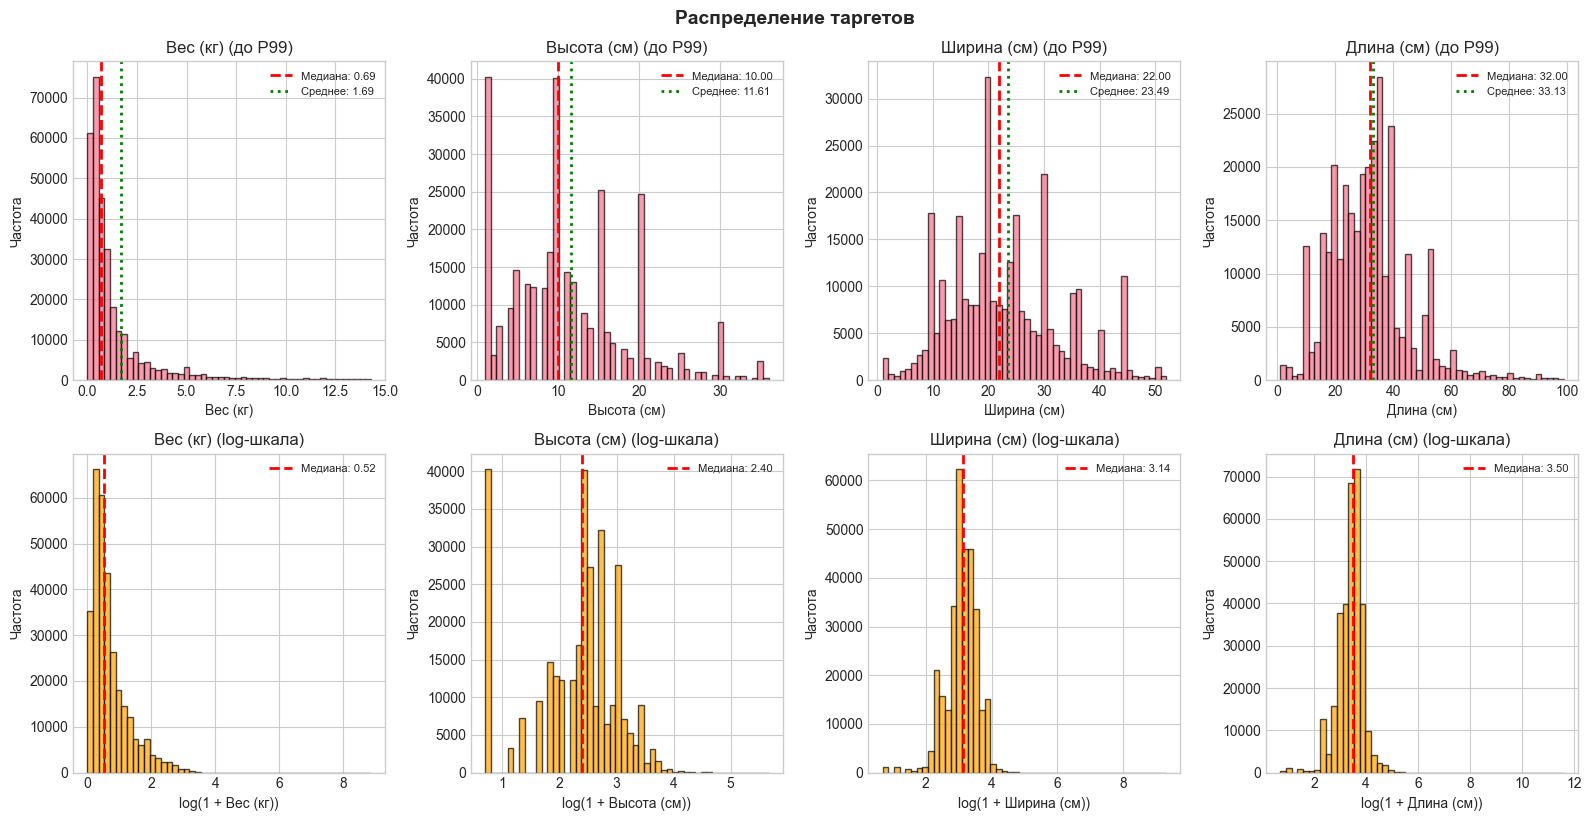

АНАЛИЗ РАСПРЕДЕЛЕНИЙ ТАРГЕТОВ

- Вес (кг) (real_weight):
- Медиана: 0.69, Среднее: 1.69 (ratio: 2.45x)
- 50% данных в диапазоне [0.34, 1.50]
- Сильный сдвиг вправо (mean/median = 2.45)

- Высота (см) (real_height):
- Медиана: 10.00, Среднее: 11.61 (ratio: 1.16x)
- 50% данных в диапазоне [6.00, 15.00]
- Распределение близко к симметричному

- Ширина (см) (real_width):
- Медиана: 22.00, Среднее: 23.49 (ratio: 1.07x)
- 50% данных в диапазоне [16.00, 30.00]
- Распределение близко к симметричному

- Длина (см) (real_length):
- Медиана: 32.00, Среднее: 33.13 (ratio: 1.04x)
- 50% данных в диапазоне [22.00, 40.00]
- Распределение близко к симметричному


In [10]:
# Распределение таргетов - гистограммы

fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Названия для графиков
target_names: Dict[str, str] = {
    'real_weight': 'Вес (кг)',
    'real_height': 'Высота (см)',
    'real_width': 'Ширина (см)',
    'real_length': 'Длина (см)'
}

# Верхний ряд - оригинальные распределения (с ограничением по P99 для читаемости)
for i, target in enumerate(TARGETS):
    ax = axes[0, i]
    data = train_df[target]
    p99 = data.quantile(0.99)
    data_clipped = data[data <= p99]
    ax.hist(data_clipped, bins=50, edgecolor='black', alpha=0.7)
    ax.set_title(f'{target_names[target]} (до P99)')
    ax.set_xlabel(target_names[target])
    ax.set_ylabel('Частота')
    ax.axvline(data.median(), color='red', linestyle='--', linewidth=2, label=f'Медиана: {data.median():.2f}')
    ax.axvline(data.mean(), color='green', linestyle=':', linewidth=2, label=f'Среднее: {data.mean():.2f}')
    ax.legend(fontsize=8)

# Нижний ряд - логарифмические распределения
for i, target in enumerate(TARGETS):
    ax = axes[1, i]
    data = np.log1p(train_df[target])
    ax.hist(data, bins=50, edgecolor='black', alpha=0.7, color='orange')
    ax.set_title(f'{target_names[target]} (log-шкала)')
    ax.set_xlabel(f'log(1 + {target_names[target]})')
    ax.set_ylabel('Частота')
    ax.axvline(data.median(), color='red', linestyle='--', linewidth=2, label=f'Медиана: {data.median():.2f}')
    ax.legend(fontsize=8)

plt.tight_layout()
plt.suptitle('Распределение таргетов', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Динамический вывод на основе данных
print("=" * 70)
print("АНАЛИЗ РАСПРЕДЕЛЕНИЙ ТАРГЕТОВ")
print("=" * 70)

for target in TARGETS:
    data = train_df[target]
    median_val = data.median()
    mean_val = data.mean()
    q25, q75 = data.quantile(0.25), data.quantile(0.75)
    skew_ratio = mean_val / median_val
    
    print(f"\n- {target_names[target]} ({target}):")
    print(f"- Медиана: {median_val:.2f}, Среднее: {mean_val:.2f} (ratio: {skew_ratio:.2f}x)")
    print(f"- 50% данных в диапазоне [{q25:.2f}, {q75:.2f}]")
    
    # Оценка скошенности
    if skew_ratio > 2:
        print(f"- Сильный сдвиг вправо (mean/median = {skew_ratio:.2f})")
    elif skew_ratio > 1.3:
        print(f"- Умеренный сдвиг вправо")
    else:
        print(f"- Распределение близко к симметричному")


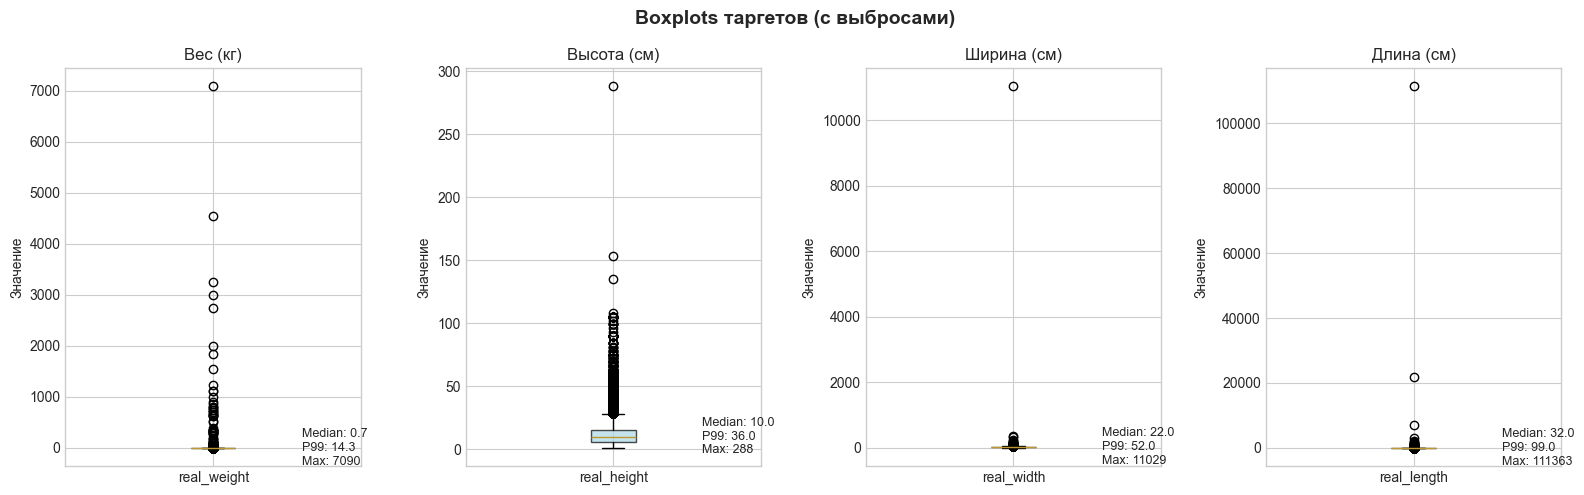

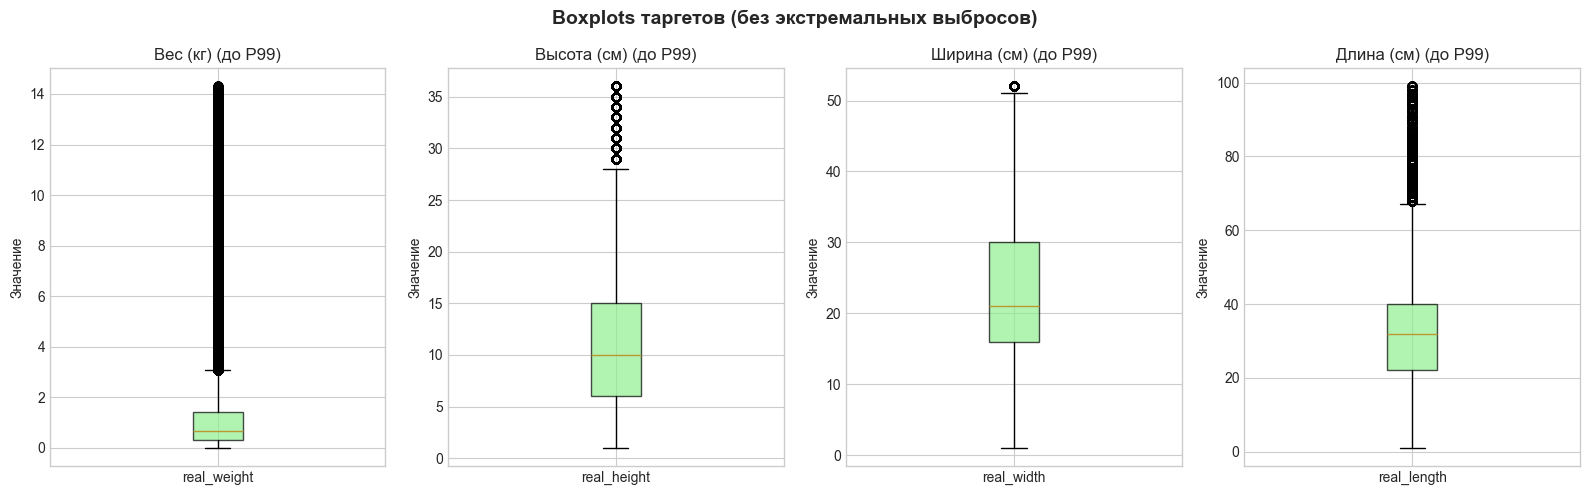

Выводы из boxplots:
- Все таргеты имеют значительные выбросы (точки выше усов)
- Вес (weight) - наиболее асимметричное распределение
- После отсечения по P99 распределения выглядят более сбалансированно


In [11]:
# Анализ выбросов в таргетах - Boxplots

# Словарь названий таргетов
target_names_rus: Dict[str, str] = {
    'real_weight': 'Вес (кг)',
    'real_height': 'Высота (см)',
    'real_width': 'Ширина (см)',
    'real_length': 'Длина (см)'
}

fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for i, target in enumerate(TARGETS):
    ax = axes[i]
    data = train_df[target]
    
    # Boxplot
    bp = ax.boxplot(data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightblue')
    bp['boxes'][0].set_alpha(0.7)
    
    # Добавляем статистику на график
    median_val = data.median()
    p99 = data.quantile(0.99)
    max_val = data.max()
    
    ax.set_title(f'{target_names_rus[target]}')
    ax.set_ylabel('Значение')
    ax.set_xticklabels([target])
    
    # Аннотация с ключевыми значениями
    stats_text = f'Median: {median_val:.1f}\nP99: {p99:.1f}\nMax: {max_val:.0f}'
    ax.text(1.3, median_val, stats_text, fontsize=9, verticalalignment='center')

plt.suptitle('Boxplots таргетов (с выбросами)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Boxplots без экстремальных выбросов (до P99)
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

for i, target in enumerate(TARGETS):
    ax = axes[i]
    data = train_df[target]
    p99 = data.quantile(0.99)
    data_clipped = data[data <= p99]
    
    bp = ax.boxplot(data_clipped, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor('lightgreen')
    bp['boxes'][0].set_alpha(0.7)
    
    ax.set_title(f'{target_names_rus[target]} (до P99)')
    ax.set_ylabel('Значение')
    ax.set_xticklabels([target])

plt.suptitle('Boxplots таргетов (без экстремальных выбросов)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Краткий вывод
print("Выводы из boxplots:")
print("- Все таргеты имеют значительные выбросы (точки выше усов)")
print("- Вес (weight) - наиболее асимметричное распределение")
print("- После отсечения по P99 распределения выглядят более сбалансированно")

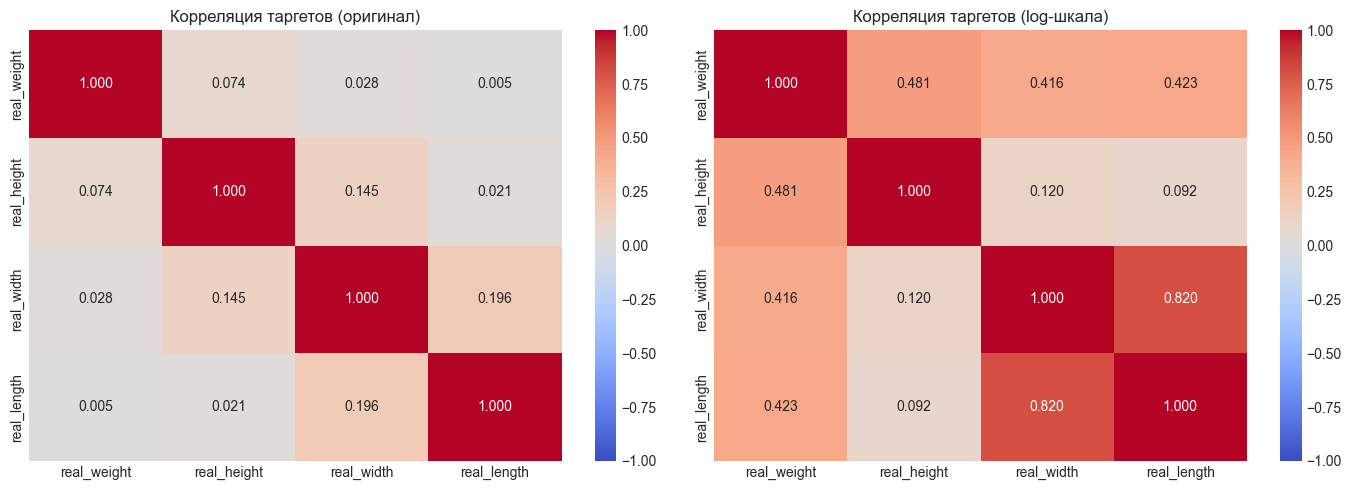

Максимальная корреляция между таргетами: 0.196
Таргеты слабо коррелируют - предсказывать каждый независимо


In [12]:
# Корреляции между таргетами

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Корреляция в оригинальной шкале
corr_matrix = train_df[TARGETS].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', ax=axes[0], vmin=-1, vmax=1)
axes[0].set_title('Корреляция таргетов (оригинал)')

# Корреляция в log-шкале
log_targets = train_df[TARGETS].apply(np.log1p)
corr_matrix_log = log_targets.corr()
sns.heatmap(corr_matrix_log, annot=True, cmap='coolwarm', center=0, 
            fmt='.3f', ax=axes[1], vmin=-1, vmax=1)
axes[1].set_title('Корреляция таргетов (log-шкала)')

plt.tight_layout()
plt.show()

# Вывод на основе данных
max_corr = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)).max().max()
print(f"Максимальная корреляция между таргетами: {max_corr:.3f}")
if max_corr < 0.3:
    print("Таргеты слабо коррелируют - предсказывать каждый независимо")

## 1.3 Анализ категориальных признаков

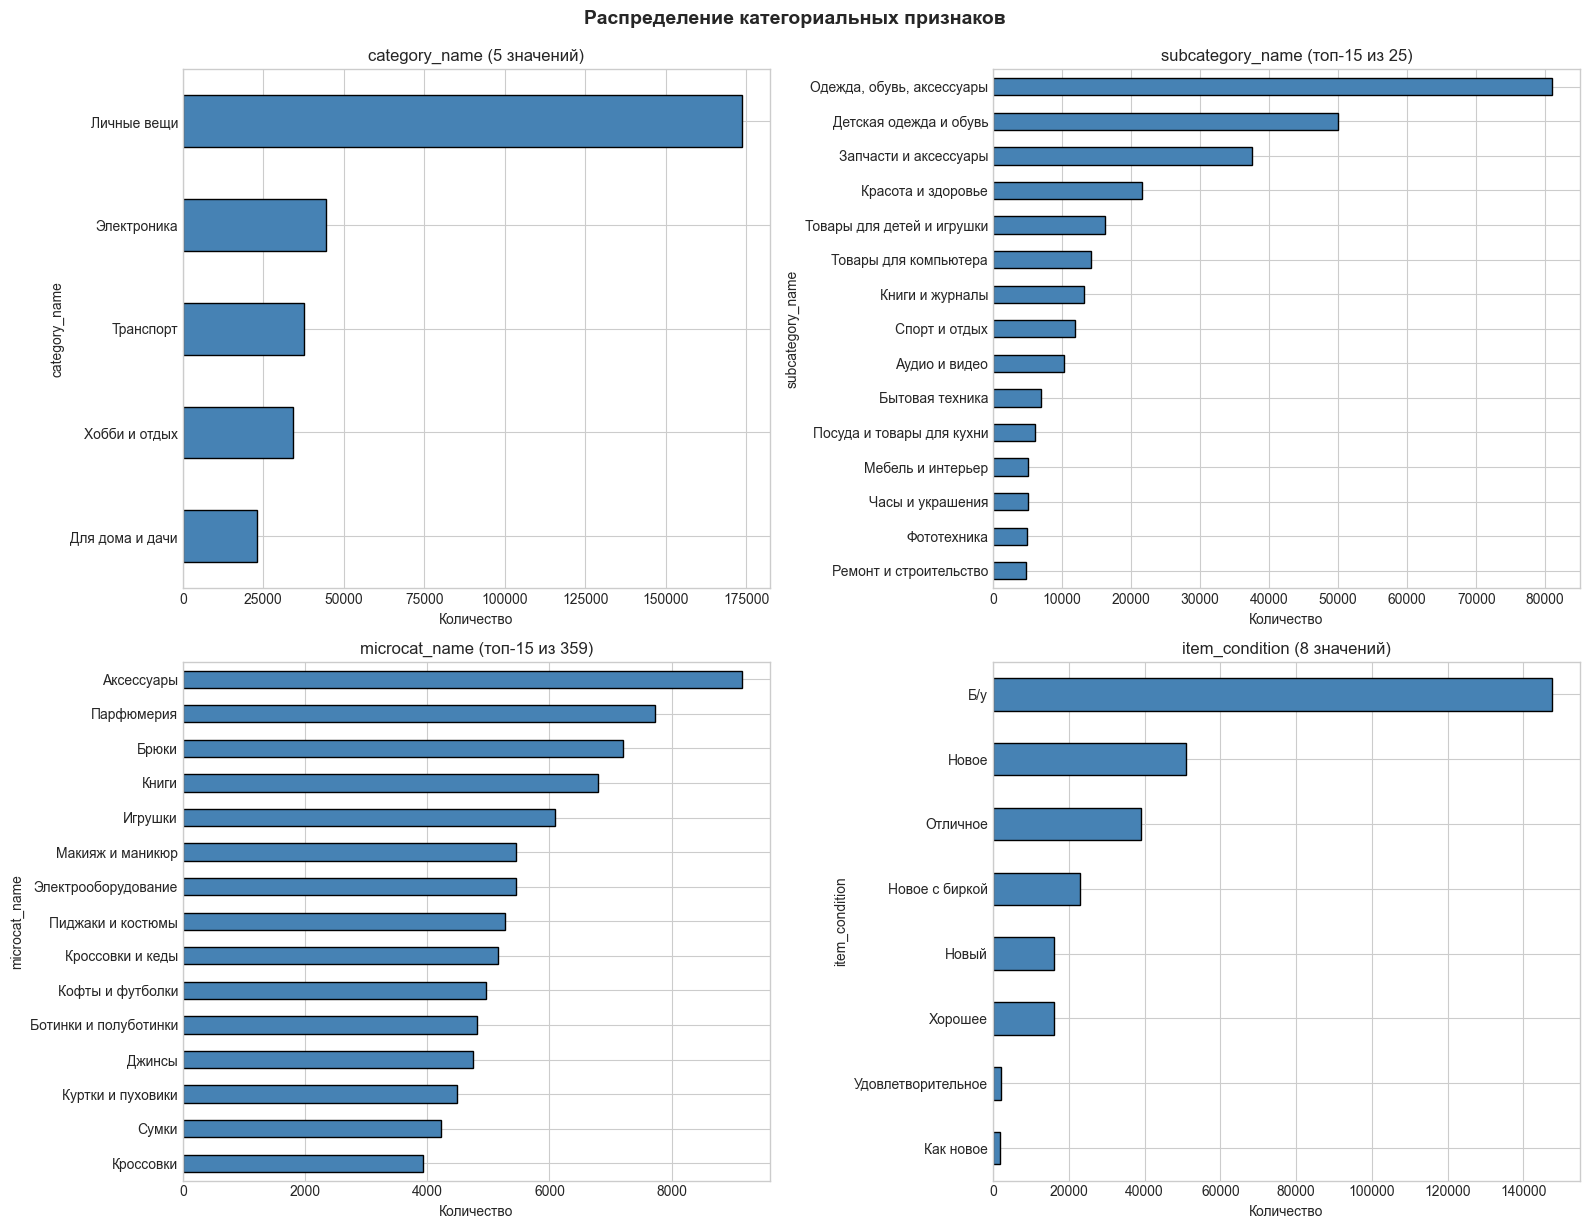

Статистика категориальных признаков:
- category_name: 5 уникальных, 0 пропусков (0.0%)
- subcategory_name: 25 уникальных, 0 пропусков (0.0%)
- microcat_name: 359 уникальных, 0 пропусков (0.0%)
- item_condition: 8 уникальных, 16294 пропусков (5.2%)


In [13]:
# Распределение категорий

cat_columns: List[str] = ['category_name', 'subcategory_name', 'microcat_name', 'item_condition']

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, col in enumerate(cat_columns):
    ax = axes[idx // 2, idx % 2]
    
    # Подсчёт значений
    value_counts = train_df[col].value_counts()
    n_unique = len(value_counts)
    
    # Для микрокатегорий показываем только топ-15
    if n_unique > 15:
        value_counts = value_counts.head(15)
        title_suffix = f' (топ-15 из {n_unique})'
    else:
        title_suffix = f' ({n_unique} значений)'
    
    # Горизонтальный barplot
    value_counts.plot(kind='barh', ax=ax, color='steelblue', edgecolor='black')
    ax.set_title(f'{col}{title_suffix}')
    ax.set_xlabel('Количество')
    ax.invert_yaxis()  # Самые частые сверху

plt.tight_layout()
plt.suptitle('Распределение категориальных признаков', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Статистика по категориям
print("Статистика категориальных признаков:")
for col in cat_columns:
    n_unique = train_df[col].nunique()
    n_missing = train_df[col].isna().sum()
    print(f"- {col}: {n_unique} уникальных, {n_missing} пропусков ({n_missing/len(train_df)*100:.1f}%)")

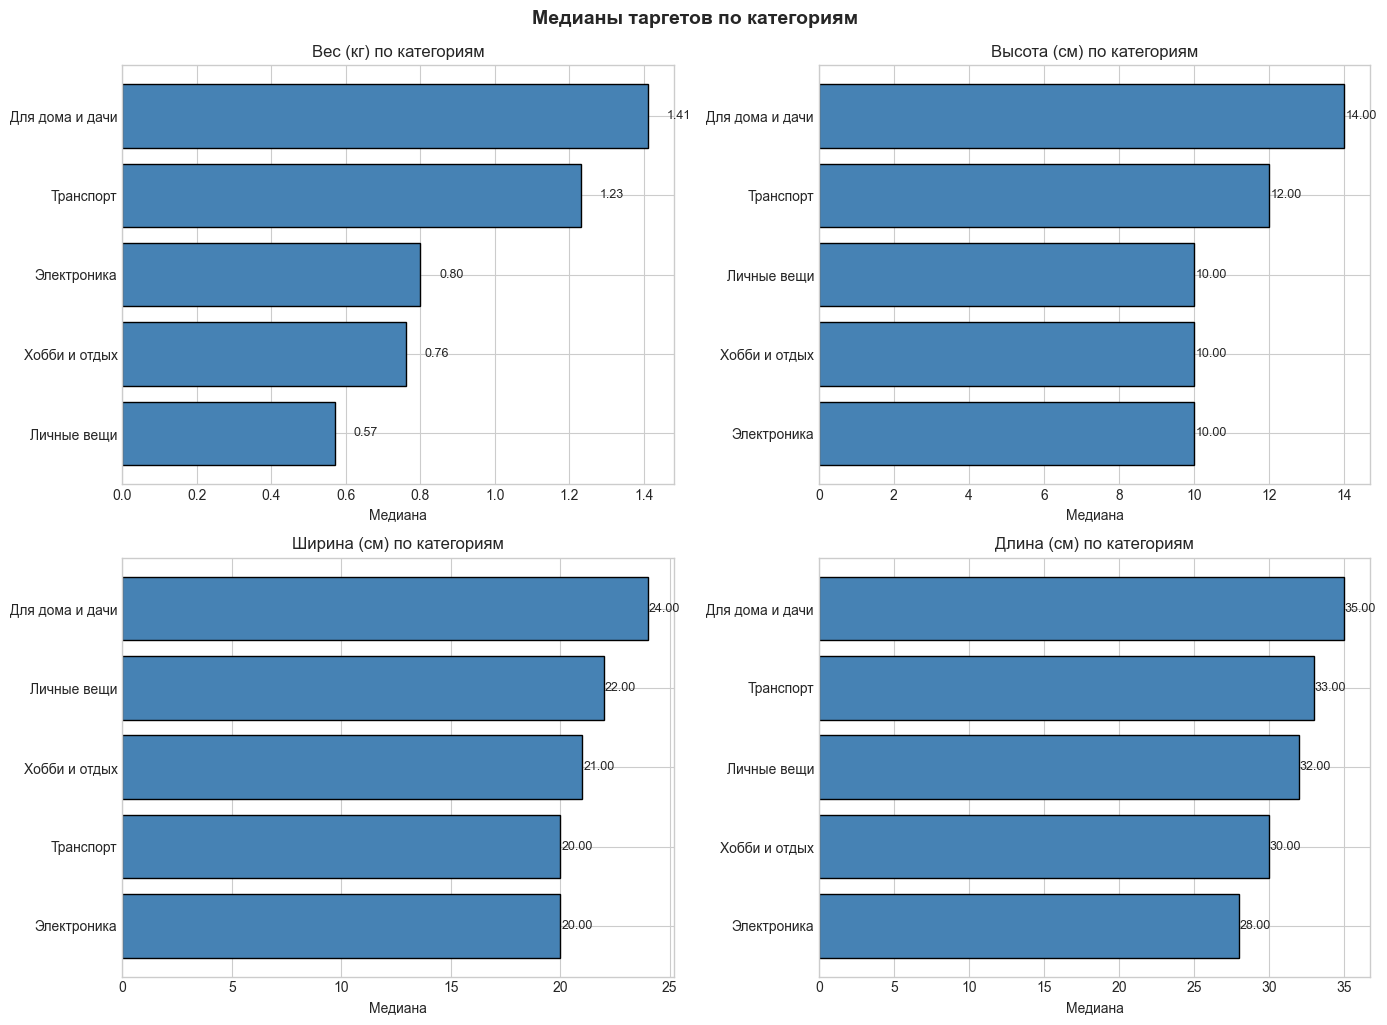

Ключевые наблюдения:
- real_weight: макс 'Для дома и дачи' (1.41), мин 'Личные вещи' (0.57), ratio 2.5x
- real_height: макс 'Для дома и дачи' (14.00), мин 'Личные вещи' (10.00), ratio 1.4x
- real_width: макс 'Для дома и дачи' (24.00), мин 'Транспорт' (20.00), ratio 1.2x
- real_length: макс 'Для дома и дачи' (35.00), мин 'Электроника' (28.00), ratio 1.2x


In [14]:
# Таргеты по категориям (category_name)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

for idx, target in enumerate(TARGETS):
    ax = axes[idx // 2, idx % 2]
    
    # Группировка по категориям
    grouped = train_df.groupby('category_name')[target].agg(['median', 'mean', 'std'])
    grouped = grouped.sort_values('median', ascending=False)
    
    # Barplot медианы
    bars = ax.barh(grouped.index, grouped['median'], color='steelblue', edgecolor='black')
    ax.set_title(f'{target_names_rus[target]} по категориям')
    ax.set_xlabel('Медиана')
    ax.invert_yaxis()
    
    # Добавляем значения на бары
    for bar, val in zip(bars, grouped['median']):
        ax.text(bar.get_width() + 0.05, bar.get_y() + bar.get_height()/2, 
                f'{val:.2f}', va='center', fontsize=9)

plt.tight_layout()
plt.suptitle('Медианы таргетов по категориям', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Вывод
print("Ключевые наблюдения:")
for target in TARGETS:
    grouped = train_df.groupby('category_name')[target].median()
    max_cat = grouped.idxmax()
    min_cat = grouped.idxmin()
    ratio = grouped.max() / grouped.min()
    print(f"- {target}: макс '{max_cat}' ({grouped.max():.2f}), мин '{min_cat}' ({grouped.min():.2f}), ratio {ratio:.1f}x")

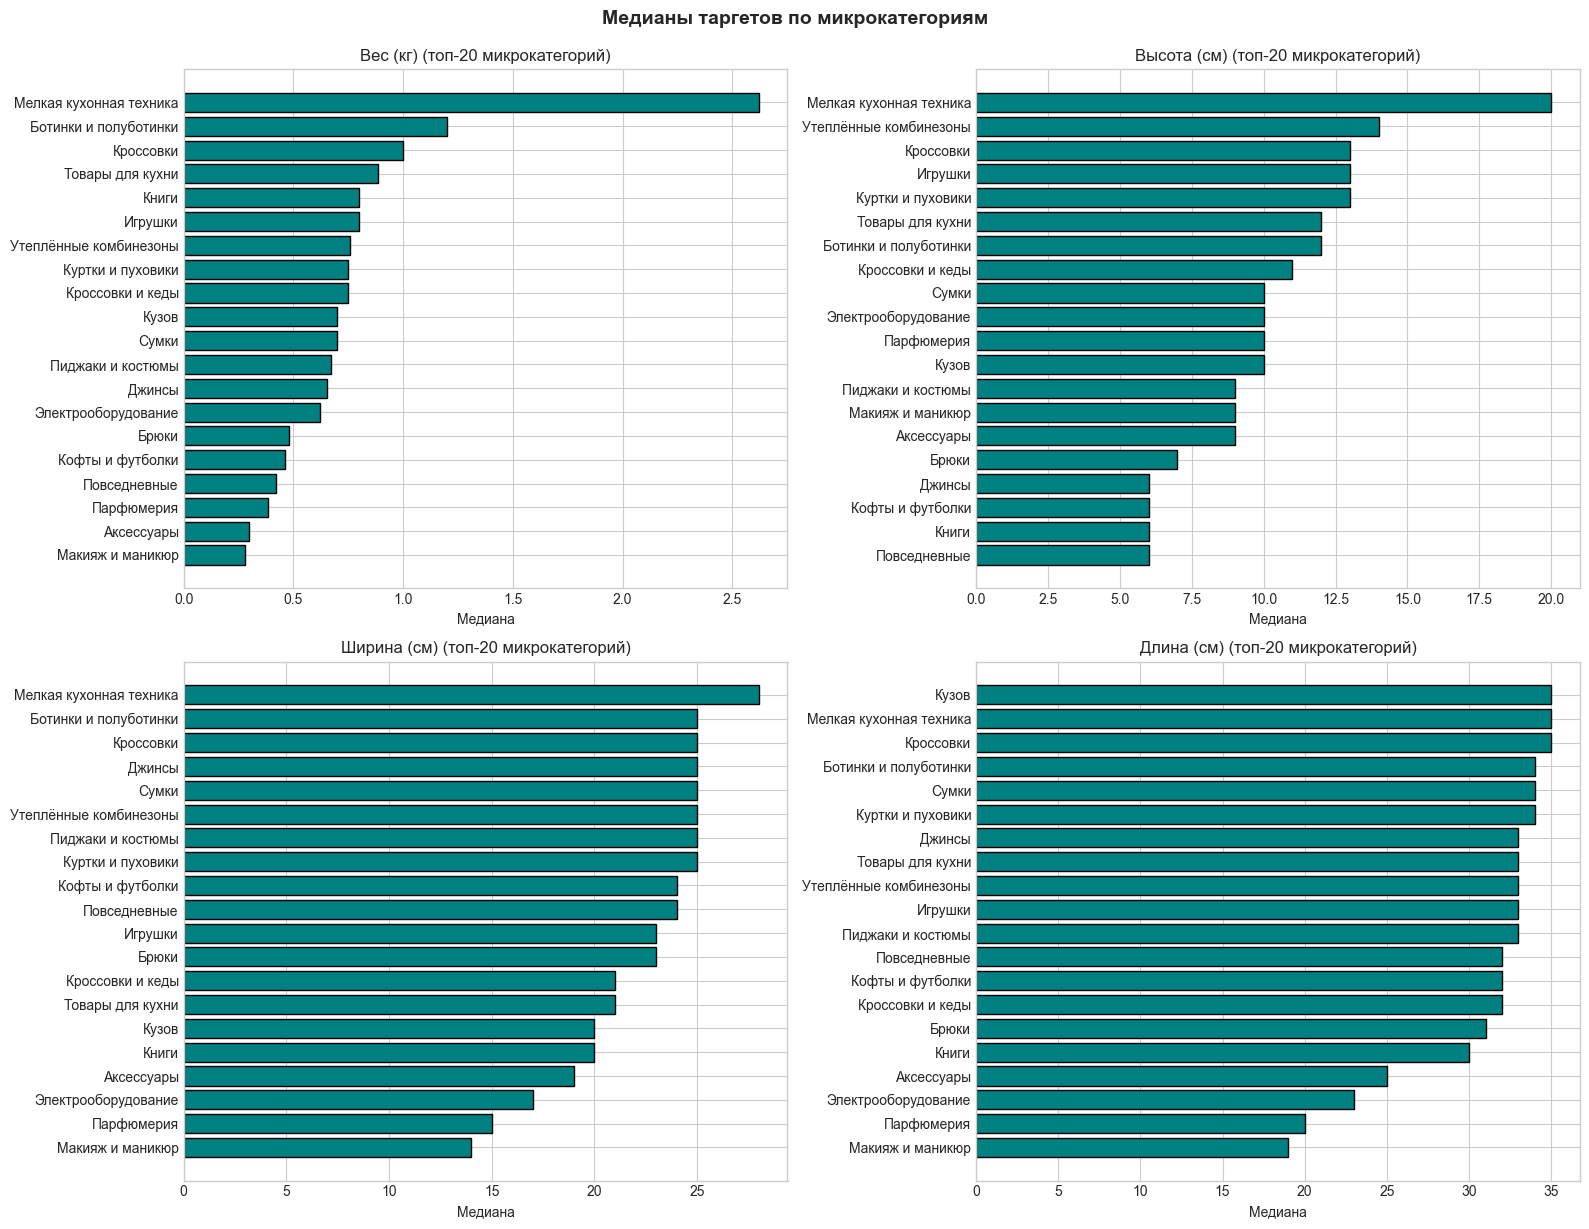

Разброс таргетов по микрокатегориям (все 359):
- real_weight: min=0.10, max=7.69, ratio=76.9x
- real_height: min=1.00, max=31.00, ratio=31.0x
- real_width: min=10.00, max=44.00, ratio=4.4x
- real_length: min=15.00, max=62.00, ratio=4.1x


In [15]:
# Таргеты по микрокатегориям (топ-20 по размеру)

# Топ-20 микрокатегорий по количеству
top_microcats = train_df['microcat_name'].value_counts().head(20).index.tolist()
df_top_micro = train_df[train_df['microcat_name'].isin(top_microcats)]

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, target in enumerate(TARGETS):
    ax = axes[idx // 2, idx % 2]
    
    # Группировка по микрокатегориям
    grouped = df_top_micro.groupby('microcat_name')[target].median()
    grouped = grouped.sort_values(ascending=False)
    
    # Barplot
    bars = ax.barh(grouped.index, grouped.values, color='teal', edgecolor='black')
    ax.set_title(f'{target_names_rus[target]} (топ-20 микрокатегорий)')
    ax.set_xlabel('Медиана')
    ax.invert_yaxis()

plt.tight_layout()
plt.suptitle('Медианы таргетов по микрокатегориям', y=1.02, fontsize=14, fontweight='bold')
plt.show()

# Анализ разброса по микрокатегориям
print("Разброс таргетов по микрокатегориям (все 359):")
for target in TARGETS:
    grouped = train_df.groupby('microcat_name')[target].median()
    print(f"- {target}: min={grouped.min():.2f}, max={grouped.max():.2f}, ratio={grouped.max()/grouped.min():.1f}x")

## 1.4 Анализ числовых признаков

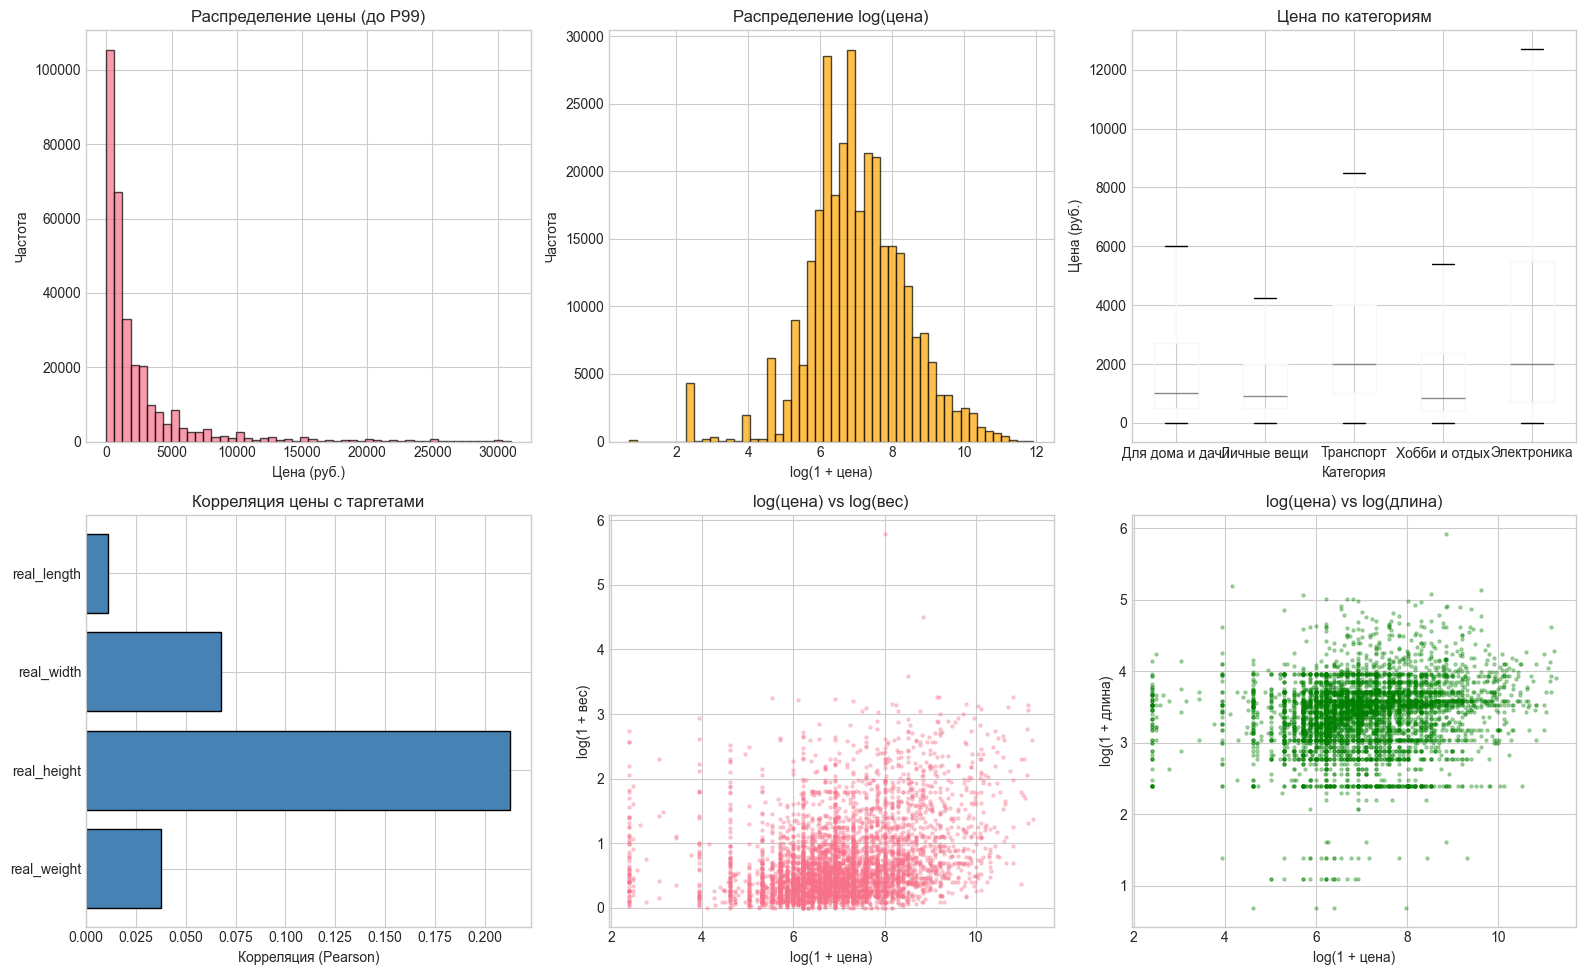

Статистика цены:
- Медиана: 1000 руб., Среднее: 2897 руб.
- Диапазон: [1, 150000] руб.

Корреляция цены с таргетами:
- real_weight: 0.038
- real_height: 0.212
- real_width: 0.068
- real_length: 0.011


In [16]:
# Анализ цены товара (item_price)

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Распределение цены
ax = axes[0, 0]
price_data = train_df['item_price']
ax.hist(price_data[price_data <= price_data.quantile(0.99)], bins=50, edgecolor='black', alpha=0.7)
ax.set_title('Распределение цены (до P99)')
ax.set_xlabel('Цена (руб.)')
ax.set_ylabel('Частота')

# Log-распределение цены
ax = axes[0, 1]
ax.hist(np.log1p(price_data), bins=50, edgecolor='black', alpha=0.7, color='orange')
ax.set_title('Распределение log(цена)')
ax.set_xlabel('log(1 + цена)')
ax.set_ylabel('Частота')

# Цена по категориям
ax = axes[0, 2]
train_df.boxplot(column='item_price', by='category_name', ax=ax, showfliers=False)
ax.set_title('Цена по категориям')
ax.set_xlabel('Категория')
ax.set_ylabel('Цена (руб.)')
plt.suptitle('')  # Убираем автоматический заголовок

# Корреляция цены с таргетами
ax = axes[1, 0]
price_target_corr = train_df[['item_price'] + TARGETS].corr()['item_price'][1:]
bars = ax.barh(price_target_corr.index, price_target_corr.values, color='steelblue', edgecolor='black')
ax.set_title('Корреляция цены с таргетами')
ax.set_xlabel('Корреляция (Pearson)')
ax.axvline(0, color='black', linestyle='-', linewidth=0.5)

# Scatter: цена vs вес
ax = axes[1, 1]
sample = train_df.sample(min(5000, len(train_df)), random_state=42)
ax.scatter(np.log1p(sample['item_price']), np.log1p(sample['real_weight']), alpha=0.3, s=5)
ax.set_title('log(цена) vs log(вес)')
ax.set_xlabel('log(1 + цена)')
ax.set_ylabel('log(1 + вес)')

# Scatter: цена vs длина
ax = axes[1, 2]
ax.scatter(np.log1p(sample['item_price']), np.log1p(sample['real_length']), alpha=0.3, s=5, color='green')
ax.set_title('log(цена) vs log(длина)')
ax.set_xlabel('log(1 + цена)')
ax.set_ylabel('log(1 + длина)')

plt.tight_layout()
plt.show()

# Статистика
print("Статистика цены:")
print(f"- Медиана: {price_data.median():.0f} руб., Среднее: {price_data.mean():.0f} руб.")
print(f"- Диапазон: [{price_data.min():.0f}, {price_data.max():.0f}] руб.")
print(f"\nКорреляция цены с таргетами:")
for target in TARGETS:
    corr = train_df['item_price'].corr(train_df[target])
    print(f"- {target}: {corr:.3f}")

## Выводы из EDA

Посмотрели на данные, теперь понятно с чем работаем.

### Что узнали про таргеты

Все четыре величины (вес, высота, ширина, длина) почти не связаны между собой. Корреляция максимум ~0.2.

Вес - самый проблемный таргет. Среднее значение в ~2.5 раза больше медианы, много выбросов. Остальные таргеты ведут себя спокойнее.

Есть явные аномалии: вес до 7 тонн, длина больше километра. Это либо ошибки ввода, либо какие-то очень редкие случаи. При обучении модели стоит подумать об ограничении таких значений.

### Что важно для модели

Микрокатегории - главный признак. Их 359 штук, и они очень хорошо разделяют товары по размерам. Например, медиана веса по разным микрокатегориям отличается во множество раз. Это огромный разброс, который можно использовать.

Категории верхнего уровня тоже полезны. "Для дома и дачи" - самые тяжелые и крупные товары. "Личные вещи" - самые легкие.

Цена товара почти не помогает. Корреляция с весом всего 0.04. Дорогой товар не значит тяжелый.


### Что будем делать дальше

1. Обязательно применить log-трансформацию к таргетам - распределения станут нормальнее
2. Сделать target encoding по микрокатегориям - это будет сильный признак
3. Использовать категориальные признаки как есть в CatBoost
4. Заполнить пропуски в item_condition (их около 5%)
5. Рассмотреть отсечение экстремальных выбросов

# Этап 2: Feature Engineering

### Категориальные признаки

Мы будем использовать CatBoost, который умеет работать с категориями напрямую. Так что использовать энкодинги нет смысла

Нам нужно только:
- Заполнить пропуски в item_condition (иначе CatBoost выдаст ошибку)
- Передать список категориальных колонок через параметр cat_features

In [17]:
# Подготовка категориальных признаков для CatBoost

# Список категориальных колонок
CAT_FEATURES: List[str] = ['category_name', 'subcategory_name', 'microcat_name', 'item_condition']

# Заполняем пропуски в item_condition
train_df['item_condition'] = train_df['item_condition'].fillna('Unknown')
test_df['item_condition'] = test_df['item_condition'].fillna('Unknown')

print(f"Пропуски в item_condition заполнены значением 'Unknown'")
print(f"Train: {train_df['item_condition'].isna().sum()} пропусков")
print(f"Test: {test_df['item_condition'].isna().sum()} пропусков")
print(f"\nКатегориальные признаки для CatBoost: {CAT_FEATURES}")

Пропуски в item_condition заполнены значением 'Unknown'
Train: 0 пропусков
Test: 0 пропусков

Категориальные признаки для CatBoost: ['category_name', 'subcategory_name', 'microcat_name', 'item_condition']


## 2.3 Формирование финального набора признаков

In [18]:
# Формирование списка признаков для модели

# Числовые признаки
NUM_FEATURES: List[str] = ['item_price']

# Все признаки для базовой модели 
BASE_FEATURES: List[str] = CAT_FEATURES + NUM_FEATURES

print("Признаки для базовой модели CatBoost:")
print(f"- Категориальные ({len(CAT_FEATURES)}): {CAT_FEATURES}")
print(f"- Числовые ({len(NUM_FEATURES)}): {NUM_FEATURES}")
print(f"- Всего: {len(BASE_FEATURES)} признаков")

# Проверяем, что все признаки есть в данных
missing_train = [f for f in BASE_FEATURES if f not in train_df.columns]
missing_test = [f for f in BASE_FEATURES if f not in test_df.columns]

if missing_train or missing_test:
    print(f"Отсутствуют в train: {missing_train}")
    print(f"Отсутствуют в test: {missing_test}")
else:
    print("Все признаки присутствуют в данных")

Признаки для базовой модели CatBoost:
- Категориальные (4): ['category_name', 'subcategory_name', 'microcat_name', 'item_condition']
- Числовые (1): ['item_price']
- Всего: 5 признаков
Все признаки присутствуют в данных


# Этап 3: Обучение регрессора CatBoost

Обучаем 4 отдельные модели на GPU, причем предсказания на валидационном Fold кладем в датасет для обучения мета-модели.

In [19]:
# Подготовка данных для обучения
X_train = train_df[BASE_FEATURES].copy()
y_train = {target: np.log1p(train_df[target]) for target in TARGETS}  # log-трансформация таргетов

X_test = test_df[BASE_FEATURES].copy()

# Индексы категориальных признаков для CatBoost
cat_feature_indices = [X_train.columns.get_loc(col) for col in CAT_FEATURES]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Категориальные индексы: {cat_feature_indices}")
print(f"Таргеты (log-трансформированы): {list(y_train.keys())}")

X_train shape: (312908, 5)
X_test shape: (70274, 5)
Категориальные индексы: [0, 1, 2, 3]
Таргеты (log-трансформированы): ['real_weight', 'real_height', 'real_width', 'real_length']


In [20]:
# Отсечение выбросов по 99-му перцентилю

outlier_mask = pd.Series(True, index=train_df.index)
percentile_thresholds = {}

for target in TARGETS:
    p99 = train_df[target].quantile(0.99)
    percentile_thresholds[target] = p99
    outlier_mask &= (train_df[target] <= p99)

# Применяем маску к обучающим данным
n_before = len(X_train)
X_train = X_train[outlier_mask]
y_train = {target: np.log1p(train_df.loc[outlier_mask, target]) for target in TARGETS}
n_after = len(X_train)

print(f"Отсечение выбросов по P99: {n_before:,} → {n_after:,} строк")
print(f"Удалено: {n_before - n_after:,} ({(n_before - n_after) / n_before * 100:.2f}%)")
print(f"\nПороги P99:")
for target, threshold in percentile_thresholds.items():
    print(f"- {target}: {threshold:.2f}")

Отсечение выбросов по P99: 312,908 → 303,575 строк
Удалено: 9,333 (2.98%)

Пороги P99:
- real_weight: 14.30
- real_height: 36.00
- real_width: 52.00
- real_length: 99.00


In [21]:
# Параметры CatBoost

# Сетка гиперпараметров для поиска. По ней я нашел лучшие параметры из заданных, я их выписал в params_per_target
# param_grid = {
#     'depth': [6, 8],
#     'learning_rate': [0.03, 0.1],
#     'l2_leaf_reg': [3, 5],
#     'iterations': [500, 1000]
# }

# Фиксированные параметры для каждого таргета
params_per_target = {
    'real_weight': {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000},
    'real_height': {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 1000},
    'real_width': {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000},
    'real_length': {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000},
}


base_params = {
    'task_type': 'GPU',
    'devices': '0',
    'random_seed': 42,
    'verbose': 0,
    'early_stopping_rounds': 50,
    'cat_features': cat_feature_indices
}


kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Словарь для хранения лучших моделей и результатов
best_models: Dict[str, CatBoostRegressor] = {}
best_params: Dict[str, dict] = {}
cv_results: Dict[str, dict] = {}

print("Фиксированные параметры CatBoost:")
for target, params in params_per_target.items():
    print(f"- {target}: {params}")
print(f"\nФолдов: {kfold.n_splits}")
print(f"Обучение на: GPU")

Фиксированные параметры CatBoost:
- real_weight: {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000}
- real_height: {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 5, 'iterations': 1000}
- real_width: {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000}
- real_length: {'depth': 8, 'learning_rate': 0.1, 'l2_leaf_reg': 3, 'iterations': 1000}

Фолдов: 5
Обучение на: GPU


In [22]:
# Функция OOF для CatBoost

def get_catboost_oof(
    X: pd.DataFrame,
    y_dict: Dict[str, pd.Series],
    X_test: pd.DataFrame,
    params_per_target: Dict[str, dict],
    base_params: dict,
    n_splits: int = 5
) -> Tuple[np.ndarray, np.ndarray, Dict[str, float]]:
    """
    Возвращает OOF-предсказания CatBoost для всех таргетов.
    
    Args:
        X: Табличные признаки train
        y_dict: Словарь {target_name: y_values} (log-scale)
        X_test: Табличные признаки test
        params_per_target: Параметры для каждого таргета
        base_params: Базовые параметры CatBoost
        n_splits: Количество фолдов
    
    Returns:
        oof_preds: (N_train, 4) - OOF предсказания для train
        test_preds: (N_test, 4) - Усреднённые предсказания для test
        cv_scores: Словарь {target: MAE}
    """
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    n_train = len(X)
    n_test = len(X_test)
    n_targets = len(TARGETS)
    
    oof_preds = np.zeros((n_train, n_targets))
    test_preds = np.zeros((n_test, n_targets))
    cv_scores = {}
    
    total_start = time.time()
    
    for target_idx, target in enumerate(TARGETS):
        print(f"\n{'='*60}")
        print(f"[{target_idx+1}/{n_targets}] CatBoost OOF для: {target}")
        print(f"{'='*60}")
        
        start_time = time.time()
        y = y_dict[target]
        
        # Параметры модели
        target_params = params_per_target[target].copy()
        model_params = {k: v for k, v in base_params.items() if k != 'cat_features'}
        model_params.update(target_params)
        
        test_fold_preds = []
        fold_scores = []
        
        for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(X)):
            X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
            y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]
            
            model = CatBoostRegressor(**model_params)
            model.fit(
                X_tr, y_tr,
                eval_set=(X_val, y_val),
                cat_features=cat_feature_indices,
                verbose=0
            )
            
            # OOF предсказания для validation fold
            val_preds = model.predict(X_val)
            oof_preds[val_idx, target_idx] = val_preds
            
            # Предсказания на test
            test_fold_preds.append(model.predict(X_test))
            
            # MAE на валидации
            mae = np.mean(np.abs(val_preds - y_val))
            fold_scores.append(mae)
            
            print(f"  Fold {fold_idx+1}/{n_splits}: MAE = {mae:.4f}")
        
        # Усредняем test предсказания по всем фолдам
        test_preds[:, target_idx] = np.mean(test_fold_preds, axis=0)
        
        # Средний MAE по фолдам
        mean_mae = np.mean(fold_scores)
        cv_scores[target] = mean_mae
        
        elapsed = time.time() - start_time
        print(f"  CV MAE: {mean_mae:.4f} (время: {elapsed:.1f}с)")
    
    total_elapsed = time.time() - total_start
    print(f"\n{'='*60}")
    print(f"CatBoost OOF завершён за {total_elapsed/60:.1f} мин")
    print(f"{'='*60}")
    
    return oof_preds, test_preds, cv_scores

print("Функция get_catboost_oof определена")

Функция get_catboost_oof определена


In [23]:
# Получение OOF предсказаний CatBoost

catboost_oof, catboost_test, catboost_cv_scores = get_catboost_oof(
    X=X_train,
    y_dict=y_train,
    X_test=X_test,
    params_per_target=params_per_target,
    base_params=base_params,
    n_splits=5
)

print(f"\nРезультаты CatBoost OOF:")
print(f"- OOF shape: {catboost_oof.shape}")
print(f"- Test shape: {catboost_test.shape}")
print(f"\nCV MAE по таргетам:")
for target, mae in catboost_cv_scores.items():
    print(f"  {target}: {mae:.4f}")
print(f"\nСредний CV MAE: {np.mean(list(catboost_cv_scores.values())):.4f}")


[1/4] CatBoost OOF для: real_weight
  Fold 1/5: MAE = 0.2800
  Fold 2/5: MAE = 0.2770
  Fold 3/5: MAE = 0.2795
  Fold 4/5: MAE = 0.2809
  Fold 5/5: MAE = 0.2790
  CV MAE: 0.2792 (время: 160.6с)

[2/4] CatBoost OOF для: real_height
  Fold 1/5: MAE = 0.5299
  Fold 2/5: MAE = 0.5319
  Fold 3/5: MAE = 0.5303
  Fold 4/5: MAE = 0.5314
  Fold 5/5: MAE = 0.5311
  CV MAE: 0.5309 (время: 129.2с)

[3/4] CatBoost OOF для: real_width
  Fold 1/5: MAE = 0.3032
  Fold 2/5: MAE = 0.3032
  Fold 3/5: MAE = 0.3017
  Fold 4/5: MAE = 0.3048
  Fold 5/5: MAE = 0.3029
  CV MAE: 0.3032 (время: 153.2с)

[4/4] CatBoost OOF для: real_length
  Fold 1/5: MAE = 0.2943
  Fold 2/5: MAE = 0.2949
  Fold 3/5: MAE = 0.2938
  Fold 4/5: MAE = 0.2961
  Fold 5/5: MAE = 0.2940
  CV MAE: 0.2946 (время: 122.8с)

CatBoost OOF завершён за 9.4 мин

Результаты CatBoost OOF:
- OOF shape: (303575, 4)
- Test shape: (70274, 4)

CV MAE по таргетам:
  real_weight: 0.2792
  real_height: 0.5309
  real_width: 0.3032
  real_length: 0.2946

Ср

In [ ]:
# Создание мета-таблицы для стекинга

# Названия колонок для CatBoost предсказаний
catboost_cols = [f'catboost_{t.replace("real_", "")}' for t in TARGETS]

# Создаём meta_train_df с OOF предсказаниями CatBoost
meta_train_df = pd.DataFrame(
    catboost_oof,
    columns=catboost_cols,
    index=X_train.index
)

# Создаём meta_test_df с test предсказаниями
meta_test_df = pd.DataFrame(
    catboost_test,
    columns=catboost_cols,
    index=X_test.index
)

print("Мета-таблицы созданы:")
print(f"- meta_train_df: {meta_train_df.shape}")
print(f"- meta_test_df: {meta_test_df.shape}")
print(f"\nКолонки: {list(meta_train_df.columns)}")
print(f"\nmeta_train_df.head():")
print(meta_train_df.head())

Мета-таблицы созданы:
- meta_train_df: (303575, 4)
- meta_test_df: (70274, 4)

Колонки: ['catboost_weight', 'catboost_height', 'catboost_width', 'catboost_length']

meta_train_df.head():
   catboost_weight  catboost_height  catboost_width  catboost_length
0         1.011961         2.715252        3.175496         3.596422
1         1.083228         2.752173        3.441491         3.695754
2         0.425723         2.110448        2.770155         3.094964
3         1.218788         2.830441        3.293460         3.516051
4         0.369786         1.936206        3.078254         3.371429


In [25]:
# Предсказания CatBoost (из OOF) и формирование промежуточного сабмита

# Используем catboost_test из OOF (усреднённые по 5 фолдам)
predictions = {}
for idx, target in enumerate(TARGETS):
    col_name = target.replace('real_', '')
    # Обратная трансформация: expm1 
    predictions[col_name] = np.expm1(catboost_test[:, idx])
    # Защита от отрицательных значений
    predictions[col_name] = np.maximum(predictions[col_name], 0.001)

submission_catboost = pd.DataFrame({
    'item_id': test_df['item_id'],
    'weight': predictions['weight'],
    'height': predictions['height'],
    'width': predictions['width'],
    'length': predictions['length']
})

# Сохраняем
submission_catboost.to_csv('submission_catboost_oof.csv', index=False)

print("Статистика предсказаний CatBoost (OOF):")
print(submission_catboost[['weight', 'height', 'width', 'length']].describe().round(2))

print(f"\nСабмит сохранён: submission_catboost_oof.csv")
print(f"Размер: {len(submission_catboost)} строк")

Статистика предсказаний CatBoost (OOF):
         weight    height     width    length
count  70274.00  70274.00  70274.00  70274.00
mean       1.06      9.11     21.02     28.72
std        0.92      3.57      4.29      5.54
min        0.07      2.86      9.88     13.96
25%        0.50      6.47     17.89     25.14
50%        0.76      8.63     21.08     29.08
75%        1.24     11.17     24.16     32.36
max       11.32     29.07     43.95     69.76

Сабмит сохранён: submission_catboost_oof.csv
Размер: 70274 строк


# Этап 4: Продвинутые модели

## 4.1 Текстовые эмбеддинги (rubert-tiny2)

Извлекаем эмбеддинги из title + description с помощью cointegrated/rubert-tiny2 и добавляем их к табличным признакам.

In [26]:
# Загрузка модели rubert-tiny2 для текстовых эмбеддингов

# Загружаем модель и токенизатор
MODEL_NAME = 'cointegrated/rubert-tiny2'
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
text_model = AutoModel.from_pretrained(MODEL_NAME).to(device)
text_model.eval()

print(f"Модель {MODEL_NAME} загружена")
print(f"- Размер эмбеддинга: {text_model.config.hidden_size}")

Модель cointegrated/rubert-tiny2 загружена
- Размер эмбеддинга: 312


In [27]:
# Функция для извлечения текстовых эмбеддингов

def get_text_embeddings(
    texts: List[str],
    tokenizer,
    model,
    device: torch.device,
    batch_size: int = 64,
    max_length: int = 128
) -> np.ndarray:
    """
    Извлекает эмбеддинги для списка текстов с помощью BERT-like модели.
    
    Args:
        texts: Список текстов
        tokenizer: Токенизатор
        model: Модель
        device: Устройство (cuda/cpu)
        batch_size: Размер батча
        max_length: Максимальная длина токенов
    
    Returns:
        Массив эмбеддингов shape (len(texts), hidden_size)
    """
    embeddings = []
    
    model.eval()
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="Извлечение эмбеддингов"):
            batch_texts = texts[i:i + batch_size]
            
            # Токенизация
            encoded = tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=max_length,
                return_tensors='pt'
            ).to(device)
            
            
            outputs = model(**encoded)
            
            # Берём CLS токен (первый токен) как эмбеддинг предложения
            cls_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeddings)
    
    return np.vstack(embeddings)

print("Функция get_text_embeddings определена")

Функция get_text_embeddings определена


In [28]:
# Подготовка текстов и извлечение эмбеддингов

# Объединяем title + description
def prepare_texts(df: pd.DataFrame) -> List[str]:
    """Объединяет title и description в один текст."""
    texts = []
    for _, row in df.iterrows():
        title = str(row['title']) if pd.notna(row['title']) else ''
        desc = str(row['description']) if pd.notna(row['description']) else ''
        # Объединяем с разделителем
        combined = f"{title} [SEP] {desc}"
        texts.append(combined)
    return texts

print("Подготовка текстов...")
train_texts = prepare_texts(train_df)
test_texts = prepare_texts(test_df)

print(f"- Train текстов: {len(train_texts):,}")
print(f"- Test текстов: {len(test_texts):,}")
print(f"- Пример: {train_texts[0][:200]}...")

Подготовка текстов...
- Train текстов: 312,908
- Test текстов: 70,274
- Пример: Ручка АКПП mercedes w203 avangarde [SEP] Ручка рычаг акпп на Мерседес В203 mercedes w203 avangarde в хорошем состоянии 

Отправлю транспортной компанией...


In [29]:
# # Извлечение эмбеддингов для train и test

# # batch_size=64 оптимален для RTX 3060 (12GB VRAM)
# # Если GPU с меньшей памятью — уменьшить до 32

# print("Извлечение эмбеддингов для train...")
# train_text_embeddings = get_text_embeddings(
#     train_texts,
#     tokenizer,
#     text_model,
#     device,
#     batch_size=64,
#     max_length=128
# )

# print(f"\nИзвлечение эмбеддингов для test...")
# test_text_embeddings = get_text_embeddings(
#     test_texts,
#     tokenizer,
#     text_model,
#     device,
#     batch_size=64,
#     max_length=128
# )

# print(f"\nЭмбеддинги извлечены:")
# print(f"- Train: {train_text_embeddings.shape}")
# print(f"- Test: {test_text_embeddings.shape}")

In [30]:
# # Сохранение эмбеддингов на диск (чтобы не извлекать повторно)

# np.save('train_text_embeddings.npy', train_text_embeddings)
# np.save('test_text_embeddings.npy', test_text_embeddings)

# print("Эмбеддинги сохранены:")
# print("- train_text_embeddings.npy")
# print("- test_text_embeddings.npy")

In [31]:
# [ОПЦИОНАЛЬНО] Загрузка эмбеддингов с диска (если уже извлечены)

train_text_embeddings = np.load('train_text_embeddings.npy')
test_text_embeddings = np.load('test_text_embeddings.npy')
print(f"Эмбеддинги загружены: train {train_text_embeddings.shape}, test {test_text_embeddings.shape}")

Эмбеддинги загружены: train (312908, 312), test (70274, 312)


In [32]:
# Применяем маску выбросов к текстовым эмбеддингам

# outlier_mask был создан ранее при отсечении P99
train_text_emb_filtered = train_text_embeddings[outlier_mask.values]

print(f"Текстовые эмбеддинги после фильтрации выбросов:")
print(f"- Train: {train_text_emb_filtered.shape}")
print(f"- Test: {test_text_embeddings.shape}")

Текстовые эмбеддинги после фильтрации выбросов:
- Train: (303575, 312)
- Test: (70274, 312)


In [33]:
# Определение MLP для текстовых эмбеддингов

class EmbeddingMLP(nn.Module):
    """
    Простая полносвязная сеть для предсказания 4 таргетов по эмбеддингам.
    
    Архитектура:
        input_dim -> 128 -> ReLU -> Dropout(0.3)
        128 -> 64 -> ReLU -> Dropout(0.2)
        64 -> 4 (output)
    """
    def __init__(self, input_dim: int, hidden_dims: List[int] = [128, 64], output_dim: int = 4, dropout: float = 0.3):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        for i, h_dim in enumerate(hidden_dims):
            layers.append(nn.Linear(prev_dim, h_dim))
            layers.append(nn.Mish())
            # Уменьшаем dropout к концу сети
            drop_rate = dropout * (1 - i * 0.3)
            layers.append(nn.Dropout(max(0.0, drop_rate)))
            prev_dim = h_dim
        
        layers.append(nn.Linear(prev_dim, output_dim))
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

# Проверяем архитектуру
sample_model = EmbeddingMLP(input_dim=312, hidden_dims=[128, 64], output_dim=4)
print(f"Архитектура MLP для текстовых эмбеддингов:")
print(sample_model)
print(f"\nПараметров: {sum(p.numel() for p in sample_model.parameters()):,}")

Архитектура MLP для текстовых эмбеддингов:
EmbeddingMLP(
  (model): Sequential(
    (0): Linear(in_features=312, out_features=128, bias=True)
    (1): Mish()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=128, out_features=64, bias=True)
    (4): Mish()
    (5): Dropout(p=0.21, inplace=False)
    (6): Linear(in_features=64, out_features=4, bias=True)
  )
)

Параметров: 48,580


In [ ]:

def compute_grad_norm(model):
    total_norm = 0.0
    for p in model.parameters():
        if p.grad is not None:
            param_norm = p.grad.data.norm(2)
            total_norm += param_norm.item() ** 2
    return total_norm ** 0.5





# Функция OOF для MLP

def get_mlp_oof(
    embeddings: np.ndarray,
    y_dict: Dict[str, pd.Series],
    embeddings_test: np.ndarray,
    input_dim: int,
    hidden_dims: List[int] = [128, 64],
    n_splits: int = 5,
    epochs: int = 50,
    batch_size: int = 512,
    lr: float = 1e-3,
    patience: int = 10,
    device: torch.device = None
) -> Tuple[np.ndarray, np.ndarray, Dict[str, float]]:
    """
    Получает OOF-предсказания MLP для эмбеддингов.
    
    Args:
        embeddings: Эмбеддинги train (N, embed_dim)
        y_dict: Словарь {target_name: y_values} (log-scale)
        embeddings_test: Эмбеддинги test (M, embed_dim)
        input_dim: Размерность входа (embed_dim)
        hidden_dims: Размеры скрытых слоёв
        n_splits: Количество фолдов
        epochs: Максимальное количество эпох
        batch_size: Размер батча
        lr: Learning rate
        patience: Терпение для early stopping
        device: Устройство (cuda/cpu)
    
    Returns:
        oof_preds: (N, 4) - OOF предсказания
        test_preds: (M, 4) - Усреднённые предсказания
        cv_scores: Словарь {target: MAE}
    """
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    n_train = len(embeddings)
    n_test = len(embeddings_test)
    n_targets = len(TARGETS)
    
    oof_preds = np.zeros((n_train, n_targets))
    test_fold_preds = []

    grad_norms = [] # TODO
    
    # Подготовка y как numpy array (N, 4)
    y_train_array = np.column_stack([y_dict[t].values for t in TARGETS])
    
    # Конвертируем test в tensor
    X_test_tensor = torch.FloatTensor(embeddings_test).to(device)
    
    total_start = time.time()
    
    for fold_idx, (train_idx, val_idx) in enumerate(kfold.split(embeddings)):
        print(f"\n{'='*50}")
        print(f"Fold {fold_idx+1}/{n_splits}")
        print(f"{'='*50}")
        
        # Разделение данных
        X_tr = embeddings[train_idx]
        X_val = embeddings[val_idx]
        y_tr = y_train_array[train_idx]
        y_val = y_train_array[val_idx]
        
        # Конвертируем в тензоры
        X_tr_tensor = torch.FloatTensor(X_tr).to(device)
        y_tr_tensor = torch.FloatTensor(y_tr).to(device)
        X_val_tensor = torch.FloatTensor(X_val).to(device)
        y_val_tensor = torch.FloatTensor(y_val).to(device)
        
        # DataLoader
        train_dataset = TensorDataset(X_tr_tensor, y_tr_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        # Модель
        model = EmbeddingMLP(input_dim=input_dim, hidden_dims=hidden_dims, output_dim=n_targets).to(device)
        
        # Optimizer и Loss
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
        criterion = nn.MSELoss()
        
        best_val_loss = float('inf')
        best_model_state = None
        patience_counter = 0
        
        for epoch in range(epochs):
            # Training
            model.train()
            train_loss = 0.0
            for batch_x, batch_y in train_loader:

                optimizer.zero_grad()

                outputs = model(batch_x)

                loss = criterion(outputs, batch_y)

                loss.backward()

                grad_norm = compute_grad_norm(model) # сохраняем норму градиента
                grad_norms.append(grad_norm)

                optimizer.step()

                train_loss += loss.item() * len(batch_x)
            train_loss /= len(X_tr)
            
            # Validation
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_val_tensor)
                val_loss = criterion(val_outputs, y_val_tensor).item()
            
            scheduler.step(val_loss)
            
            # Early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict().copy()
                patience_counter = 0
            else:
                patience_counter += 1
            
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"  Epoch {epoch+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, mean_grad_norm: {np.mean(grad_norms):.4f}")
            
            if patience_counter >= patience:
                print(f"  Early stopping at epoch {epoch+1}")
                break
        
        # Загружаем лучшую модель
        model.load_state_dict(best_model_state)
        model.eval()
        
        # OOF предсказания
        with torch.no_grad():
            val_preds = model(X_val_tensor).cpu().numpy()
            oof_preds[val_idx] = val_preds
            
            # Test предсказания
            test_preds = model(X_test_tensor).cpu().numpy()
            test_fold_preds.append(test_preds)
        
        # MAE на валидации
        val_mae = np.mean(np.abs(val_preds - y_val))
        print(f"  Fold {fold_idx+1} MAE: {val_mae:.4f}")
    
    # Усредняем test предсказания
    test_preds_avg = np.mean(test_fold_preds, axis=0)
    
    # Считаем CV MAE по таргетам
    cv_scores = {}
    for idx, target in enumerate(TARGETS):
        mae = np.mean(np.abs(oof_preds[:, idx] - y_train_array[:, idx]))
        cv_scores[target] = mae
    
    total_elapsed = time.time() - total_start
    print(f"\n{'='*50}")
    print(f"MLP OOF завершён за {total_elapsed/60:.1f} мин")
    print(f"{'='*50}")
    
    return oof_preds, test_preds_avg, cv_scores

print("Функция get_mlp_oof определена")

Функция get_mlp_oof определена


In [61]:
# Получение OOF предсказаний MLP (текстовые эмбеддинги)

mlp_text_oof, mlp_text_test, mlp_text_cv_scores = get_mlp_oof(
    embeddings=train_text_emb_filtered,
    y_dict=y_train,
    embeddings_test=test_text_embeddings,
    input_dim=312,  # rubert-tiny2 выдаёт 312-мерные эмбеддинги
    # hidden_dims=[128, 64],
    hidden_dims=[256, 128, 64, 32],
    n_splits=5,
    # epochs=50,
    epochs=100,
    batch_size=512,
    lr=1e-3,
    patience=10,
    device=device
)

print(f"\nРезультаты MLP (текст) OOF:")
print(f"- OOF shape: {mlp_text_oof.shape}")
print(f"- Test shape: {mlp_text_test.shape}")
print(f"\nCV MAE по таргетам:")
for target, mae in mlp_text_cv_scores.items():
    print(f"  {target}: {mae:.4f}")
print(f"\nСредний CV MAE: {np.mean(list(mlp_text_cv_scores.values())):.4f}")


Fold 1/5
  Epoch   1: train_loss=0.5152, val_loss=0.2988, mean_grad_norm: 0.9574
  Epoch  10: train_loss=0.2845, val_loss=0.2745, mean_grad_norm: 0.2468
  Epoch  20: train_loss=0.2755, val_loss=0.2723, mean_grad_norm: 0.1839
  Epoch  30: train_loss=0.2708, val_loss=0.2691, mean_grad_norm: 0.1771
  Epoch  40: train_loss=0.2649, val_loss=0.2683, mean_grad_norm: 0.1614
  Epoch  50: train_loss=0.2619, val_loss=0.2677, mean_grad_norm: 0.1502
  Epoch  60: train_loss=0.2567, val_loss=0.2673, mean_grad_norm: 0.1416
  Early stopping at epoch 64
  Fold 1 MAE: 0.3703

Fold 2/5
  Epoch   1: train_loss=0.5295, val_loss=0.3005, mean_grad_norm: 0.1524
  Epoch  10: train_loss=0.2849, val_loss=0.2759, mean_grad_norm: 0.1574
  Epoch  20: train_loss=0.2852, val_loss=0.2746, mean_grad_norm: 0.1623
  Epoch  30: train_loss=0.2720, val_loss=0.2713, mean_grad_norm: 0.1592
  Epoch  40: train_loss=0.2696, val_loss=0.2695, mean_grad_norm: 0.1561
  Epoch  50: train_loss=0.2619, val_loss=0.2680, mean_grad_norm: 0

In [62]:
# Добавление MLP (текст) предсказаний в мета-таблицу

# Названия колонок для MLP text предсказаний
mlp_text_cols = [f'mlp_text_{t.replace("real_", "")}' for t in TARGETS]

# Добавляем в meta_train_df
for idx, col in enumerate(mlp_text_cols):
    meta_train_df[col] = mlp_text_oof[:, idx]

# Добавляем в meta_test_df
for idx, col in enumerate(mlp_text_cols):
    meta_test_df[col] = mlp_text_test[:, idx]

print("MLP (текст) предсказания добавлены в мета-таблицы:")
print(f"- meta_train_df: {meta_train_df.shape}")
print(f"- meta_test_df: {meta_test_df.shape}")
print(f"\nКолонки: {list(meta_train_df.columns)}")
print(f"\nmeta_train_df.head():")
print(meta_train_df.head())

MLP (текст) предсказания добавлены в мета-таблицы:
- meta_train_df: (303575, 12)
- meta_test_df: (70274, 12)

Колонки: ['catboost_weight', 'catboost_height', 'catboost_width', 'catboost_length', 'mlp_text_weight', 'mlp_text_height', 'mlp_text_width', 'mlp_text_length', 'mlp_image_weight', 'mlp_image_height', 'mlp_image_width', 'mlp_image_length']

meta_train_df.head():
   catboost_weight  catboost_height  catboost_width  catboost_length  \
0         1.011961         2.715252        3.175496         3.596422   
1         1.083228         2.752173        3.441491         3.695754   
2         0.425723         2.110448        2.770155         3.094964   
3         1.218788         2.830441        3.293460         3.516051   
4         0.369786         1.936206        3.078254         3.371429   

   mlp_text_weight  mlp_text_height  mlp_text_width  mlp_text_length  \
0         0.779338         2.400496        2.915919         3.296082   
1         0.596650         2.365335        3.146566

In [64]:
# Сравнение CatBoost vs MLP (текст)

print("СРАВНЕНИЕ МОДЕЛЕЙ (CV MAE, log-scale)")
print("=" * 60)
print(f"{'Таргет':<15} {'CatBoost':>12} {'MLP (текст)':>12}")
print("-" * 60)

for target in TARGETS:
    cb_mae = catboost_cv_scores[target]
    mlp_mae = mlp_text_cv_scores[target]
    print(f"{target:<15} {cb_mae:>12.4f} {mlp_mae:>12.4f}")

avg_cb = np.mean(list(catboost_cv_scores.values()))
avg_mlp = np.mean(list(mlp_text_cv_scores.values()))
print("-" * 60)
print(f"{'СРЕДНЕЕ':<15} {avg_cb:>12.4f} {avg_mlp:>12.4f}")
print("\nCatBoost работает с табличными данными (5 признаков)")
print("MLP работает только с текстовыми эмбеддингами (312-dim)")

СРАВНЕНИЕ МОДЕЛЕЙ (CV MAE, log-scale)
Таргет              CatBoost  MLP (текст)
------------------------------------------------------------
real_weight           0.2792       0.3078
real_height           0.5309       0.5472
real_width            0.3032       0.3179
real_length           0.2946       0.3076
------------------------------------------------------------
СРЕДНЕЕ               0.3520       0.3701

CatBoost работает с табличными данными (5 признаков)
MLP работает только с текстовыми эмбеддингами (312-dim)


## 4.2 Image эмбеддинги (EfficientNet-B0)

Извлекаем эмбеддинги из изображений товаров с помощью EfficientNet-B0 (1280-dim) и обучаем MLP для предсказания таргетов.

In [65]:
# Загрузка EfficientNet-B0 для извлечения эмбеддингов

# Загружаем EfficientNet-B0 без classification head
image_model = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)  
image_model = image_model.to(device)
image_model.eval()

# Получаем размер эмбеддинга
with torch.no_grad():
    dummy_input = torch.randn(1, 3, 224, 224).to(device)
    embedding_dim = image_model(dummy_input).shape[1]

print(f"Модель EfficientNet-B0 загружена")
print(f"- Размер эмбеддинга: {embedding_dim}")
print(f"- Устройство: {device}")

# Трансформации для изображений (ImageNet нормализация)
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

Модель EfficientNet-B0 загружена
- Размер эмбеддинга: 1280
- Устройство: cuda


In [66]:
# Функция для извлечения image эмбеддингов

def get_image_embeddings(
    df: pd.DataFrame,
    images_path: Path,
    model,
    transform,
    device: torch.device,
    batch_size: int = 32
) -> np.ndarray:
    """
    Извлекает эмбеддинги для изображений товаров.
    
    Args:
        df: DataFrame с колонкой 'image_name' (имя файла)
        images_path: Путь к папке с изображениями
        model: Модель для извлечения эмбеддингов
        transform: Трансформации изображений
        device: Устройство (cuda/cpu)
        batch_size: Размер батча
    
    Returns:
        Массив эмбеддингов shape (len(df), embedding_dim)
    """
    embeddings = []
    model.eval()
    
    # Получаем список путей к изображениям
    image_paths = []
    for _, row in df.iterrows():
        img_name = row['image_name']  # Колонка называется image_name
        img_path = images_path / img_name
        image_paths.append(img_path)
    
    with torch.no_grad():
        for i in tqdm(range(0, len(image_paths), batch_size), desc="Извлечение image эмбеддингов"):
            batch_paths = image_paths[i:i + batch_size]
            batch_tensors = []
            
            for img_path in batch_paths:
                try:
                    # Загружаем и трансформируем изображение
                    img = Image.open(img_path).convert('RGB')
                    img_tensor = transform(img)
                    batch_tensors.append(img_tensor)
                except Exception as e:
                    # Если изображение не найдено или повреждено - используем нулевой тензор
                    print(f"Ошибка загрузки {img_path}: {e}")
                    batch_tensors.append(torch.zeros(3, 224, 224))
            
            # Собираем батч
            batch = torch.stack(batch_tensors).to(device)
            
            # Получаем эмбеддинги
            batch_embeddings = model(batch).cpu().numpy()
            embeddings.append(batch_embeddings)
    
    return np.vstack(embeddings)

print("Функция get_image_embeddings определена")

Функция get_image_embeddings определена


In [67]:
# # Извлечение image эмбеддингов для train и test

# print("Извлечение эмбеддингов для train изображений...")
# train_image_embeddings = get_image_embeddings(
#     df=train_df,
#     images_path=TRAIN_IMAGES_PATH,
#     model=image_model,
#     transform=image_transform,
#     device=device,
#     batch_size=32  # Меньше батч для картинок (больше памяти)
# )

# print(f"\nИзвлечение эмбеддингов для test изображений...")
# test_image_embeddings = get_image_embeddings(
#     df=test_df,
#     images_path=TEST_IMAGES_PATH,
#     model=image_model,
#     transform=image_transform,
#     device=device,
#     batch_size=32
# )

# print(f"\nImage эмбеддинги извлечены:")
# print(f"- Train: {train_image_embeddings.shape}")
# print(f"- Test: {test_image_embeddings.shape}")

In [68]:
# # Сохранение image эмбеддингов на диск

# np.save('train_image_embeddings.npy', train_image_embeddings)
# np.save('test_image_embeddings.npy', test_image_embeddings)

# print("Image эмбеддинги сохранены:")
# print("- train_image_embeddings.npy")
# print("- test_image_embeddings.npy")

In [69]:
# [ОПЦИОНАЛЬНО] Загрузка image эмбеддингов с диска (если уже извлечены)

train_image_embeddings = np.load('train_image_embeddings.npy')
test_image_embeddings = np.load('test_image_embeddings.npy')
print(f"Image эмбеддинги загружены: train {train_image_embeddings.shape}, test {test_image_embeddings.shape}")

Image эмбеддинги загружены: train (312908, 1280), test (70274, 1280)


In [70]:
# Применяем маску выбросов к image эмбеддингам

train_image_emb_filtered = train_image_embeddings[outlier_mask.values]

print(f"Image эмбеддинги после фильтрации выбросов:")
print(f"- Train: {train_image_emb_filtered.shape}")
print(f"- Test: {test_image_embeddings.shape}")

Image эмбеддинги после фильтрации выбросов:
- Train: (303575, 1280)
- Test: (70274, 1280)


In [71]:
# Получение OOF предсказаний MLP (image эмбеддинги)

# Для image используем бОльшую сеть (1280-dim вход)
mlp_image_oof, mlp_image_test, mlp_image_cv_scores = get_mlp_oof(
    embeddings=train_image_emb_filtered,
    y_dict=y_train,
    embeddings_test=test_image_embeddings,
    input_dim=1280,  # EfficientNet-B0 выдаёт 1280-мерные эмбеддинги
    # hidden_dims=[256, 64],  # Бо́льшая сеть для image
    hidden_dims=[512, 256, 128, 64],
    n_splits=5,
    # epochs=50,
    epochs=100,
    batch_size=512,
    lr=1e-3,
    patience=10,
    device=device
)

print(f"\nРезультаты MLP (image) OOF:")
print(f"- OOF shape: {mlp_image_oof.shape}")
print(f"- Test shape: {mlp_image_test.shape}")
print(f"\nCV MAE по таргетам:")
for target, mae in mlp_image_cv_scores.items():
    print(f"  {target}: {mae:.4f}")
print(f"\nСредний CV MAE: {np.mean(list(mlp_image_cv_scores.values())):.4f}")


Fold 1/5
  Epoch   1: train_loss=0.4158, val_loss=0.2634, mean_grad_norm: 0.8501
  Epoch  10: train_loss=0.2482, val_loss=0.2560, mean_grad_norm: 0.3243
  Early stopping at epoch 18
  Fold 1 MAE: 0.3634

Fold 2/5
  Epoch   1: train_loss=0.4097, val_loss=0.2680, mean_grad_norm: 0.2972
  Epoch  10: train_loss=0.2488, val_loss=0.2603, mean_grad_norm: 0.2784
  Early stopping at epoch 17
  Fold 2 MAE: 0.3650

Fold 3/5
  Epoch   1: train_loss=0.4053, val_loss=0.2634, mean_grad_norm: 0.2699
  Epoch  10: train_loss=0.2463, val_loss=0.2568, mean_grad_norm: 0.2584
  Early stopping at epoch 18
  Fold 3 MAE: 0.3660

Fold 4/5
  Epoch   1: train_loss=0.3973, val_loss=0.2666, mean_grad_norm: 0.2555
  Epoch  10: train_loss=0.2466, val_loss=0.2612, mean_grad_norm: 0.2472
  Early stopping at epoch 16
  Fold 4 MAE: 0.3652

Fold 5/5
  Epoch   1: train_loss=0.4082, val_loss=0.2663, mean_grad_norm: 0.2482
  Epoch  10: train_loss=0.2511, val_loss=0.2596, mean_grad_norm: 0.2515
  Early stopping at epoch 19
 

In [72]:
# Добавление MLP (image) предсказаний в мета-таблицу

# Названия колонок для MLP image предсказаний
mlp_image_cols = [f'mlp_image_{t.replace("real_", "")}' for t in TARGETS]

# Добавляем в meta_train_df
for idx, col in enumerate(mlp_image_cols):
    meta_train_df[col] = mlp_image_oof[:, idx]

# Добавляем в meta_test_df
for idx, col in enumerate(mlp_image_cols):
    meta_test_df[col] = mlp_image_test[:, idx]

print("MLP (image) предсказания добавлены в мета-таблицы:")
print(f"- meta_train_df: {meta_train_df.shape}")
print(f"- meta_test_df: {meta_test_df.shape}")
print(f"\nКолонки: {list(meta_train_df.columns)}")
print(f"\nmeta_train_df.head():")
print(meta_train_df.head())

MLP (image) предсказания добавлены в мета-таблицы:
- meta_train_df: (303575, 12)
- meta_test_df: (70274, 12)

Колонки: ['catboost_weight', 'catboost_height', 'catboost_width', 'catboost_length', 'mlp_text_weight', 'mlp_text_height', 'mlp_text_width', 'mlp_text_length', 'mlp_image_weight', 'mlp_image_height', 'mlp_image_width', 'mlp_image_length']

meta_train_df.head():
   catboost_weight  catboost_height  catboost_width  catboost_length  \
0         1.011961         2.715252        3.175496         3.596422   
1         1.083228         2.752173        3.441491         3.695754   
2         0.425723         2.110448        2.770155         3.094964   
3         1.218788         2.830441        3.293460         3.516051   
4         0.369786         1.936206        3.078254         3.371429   

   mlp_text_weight  mlp_text_height  mlp_text_width  mlp_text_length  \
0         0.779338         2.400496        2.915919         3.296082   
1         0.596650         2.365335        3.146566

In [73]:
# Сравнение всех трёх моделей

print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ")
print("=" * 70)
print(f"{'Таргет':<15} {'CatBoost':>12} {'MLP (текст)':>12} {'MLP (image)':>12}")
print("-" * 70)

for target in TARGETS:
    cb_mae = catboost_cv_scores[target]
    mlp_text_mae = mlp_text_cv_scores[target]
    mlp_img_mae = mlp_image_cv_scores[target]
    print(f"{target:<15} {cb_mae:>12.4f} {mlp_text_mae:>12.4f} {mlp_img_mae:>12.4f}")

avg_cb = np.mean(list(catboost_cv_scores.values()))
avg_mlp_text = np.mean(list(mlp_text_cv_scores.values()))
avg_mlp_img = np.mean(list(mlp_image_cv_scores.values()))
print("-" * 70)
print(f"{'СРЕДНЕЕ':<15} {avg_cb:>12.4f} {avg_mlp_text:>12.4f} {avg_mlp_img:>12.4f}")
print("\n- CatBoost: табличные данные (5 признаков)")
print("- MLP (текст): rubert-tiny2 эмбеддинги (312-dim)")
print("- MLP (image): EfficientNet-B0 эмбеддинги (1280-dim)")

СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ
Таргет              CatBoost  MLP (текст)  MLP (image)
----------------------------------------------------------------------
real_weight           0.2792       0.3078       0.2986
real_height           0.5309       0.5472       0.5496
real_width            0.3032       0.3179       0.3118
real_length           0.2946       0.3076       0.2996
----------------------------------------------------------------------
СРЕДНЕЕ               0.3520       0.3701       0.3649

- CatBoost: табличные данные (5 признаков)
- MLP (текст): rubert-tiny2 эмбеддинги (312-dim)
- MLP (image): EfficientNet-B0 эмбеддинги (1280-dim)


# Этап 5: Мета-модель (Stacking Level 1)

Обучаем LinearRegression на OOF-предсказаниях базовых моделей.

Для каждого таргета:
- Используем 3 признака: предсказания CatBoost, MLP (text), MLP (image)
- Обучаем отдельную LinearRegression

In [74]:
# Подготовка данных для мета-модели

# Создаём отдельные DataFrame для каждого таргета
# Каждый содержит 3 признака: предсказания от CatBoost, MLP text, MLP image

target_short_names = [t.replace('real_', '') for t in TARGETS]  # ['weight', 'height', 'width', 'length']

meta_X_train = {}
meta_X_test = {}
meta_y_train = {}

for short_name in target_short_names:
    # Колонки для данного таргета
    cols = [
        f'catboost_{short_name}',
        f'mlp_text_{short_name}',
        f'mlp_image_{short_name}'
    ]
    
    # Признаки для мета-модели
    meta_X_train[short_name] = meta_train_df[cols].copy()
    meta_X_test[short_name] = meta_test_df[cols].copy()
    
    # Таргет 
    meta_y_train[short_name] = y_train[f'real_{short_name}']

print("Данные для мета-модели подготовлены:")
for short_name in target_short_names:
    print(f"\n{short_name}:")
    print(f"  X_train: {meta_X_train[short_name].shape}")
    print(f"  X_test: {meta_X_test[short_name].shape}")
    print(f"  y_train: {len(meta_y_train[short_name])}")
    print(f"  Признаки: {list(meta_X_train[short_name].columns)}")

Данные для мета-модели подготовлены:

weight:
  X_train: (303575, 3)
  X_test: (70274, 3)
  y_train: 303575
  Признаки: ['catboost_weight', 'mlp_text_weight', 'mlp_image_weight']

height:
  X_train: (303575, 3)
  X_test: (70274, 3)
  y_train: 303575
  Признаки: ['catboost_height', 'mlp_text_height', 'mlp_image_height']

width:
  X_train: (303575, 3)
  X_test: (70274, 3)
  y_train: 303575
  Признаки: ['catboost_width', 'mlp_text_width', 'mlp_image_width']

length:
  X_train: (303575, 3)
  X_test: (70274, 3)
  y_train: 303575
  Признаки: ['catboost_length', 'mlp_text_length', 'mlp_image_length']


In [75]:
# Обучение LinearRegression для каждого таргета


meta_models: Dict[str, LinearRegression] = {}
meta_cv_scores: Dict[str, float] = {}
meta_train_preds: Dict[str, np.ndarray] = {}
meta_test_preds: Dict[str, np.ndarray] = {}

print("Обучение мета-моделей (LinearRegression)")
print("=" * 60)

for short_name in target_short_names:
    target_full = f'real_{short_name}'
    
    X = meta_X_train[short_name]
    y = meta_y_train[short_name]
    X_test_meta = meta_X_test[short_name]
    
    # Обучаем LinearRegression
    model = LinearRegression()
    model.fit(X, y)
    
    # Сохраняем модель
    meta_models[short_name] = model
    
    # Предсказания на train (для оценки качества)
    train_preds = model.predict(X)
    meta_train_preds[short_name] = train_preds
    
    # Предсказания на test
    test_preds = model.predict(X_test_meta)
    meta_test_preds[short_name] = test_preds
    
    # MAE на train 
    mae = mean_absolute_error(y, train_preds)
    meta_cv_scores[short_name] = mae
    
    # Коэффициенты модели
    coefs = dict(zip(X.columns, model.coef_))
    
    print(f"\n{target_full}:")
    print(f"  Train MAE: {mae:.4f}")
    print(f"  Коэффициенты: {', '.join([f'{k}={v:.3f}' for k, v in coefs.items()])}")
    print(f"  Intercept: {model.intercept_:.4f}")

print("\n" + "=" * 60)
print(f"Средний Train MAE: {np.mean(list(meta_cv_scores.values())):.4f}")

Обучение мета-моделей (LinearRegression)

real_weight:
  Train MAE: 0.2527
  Коэффициенты: catboost_weight=0.587, mlp_text_weight=0.342, mlp_image_weight=0.410
  Intercept: -0.2199

real_height:
  Train MAE: 0.5172
  Коэффициенты: catboost_height=0.598, mlp_text_height=0.308, mlp_image_height=0.290
  Intercept: -0.4474

real_width:
  Train MAE: 0.2936
  Коэффициенты: catboost_width=0.620, mlp_text_width=0.246, mlp_image_width=0.380
  Intercept: -0.7633

real_length:
  Train MAE: 0.2834
  Коэффициенты: catboost_length=0.576, mlp_text_length=0.250, mlp_image_length=0.427
  Intercept: -0.8659

Средний Train MAE: 0.3367


In [76]:
# Сравнение всех моделей: базовые vs мета-модель

print("СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ (MAE, log-scale)")
print("=" * 85)
print(f"{'Таргет':<15} {'CatBoost':>12} {'MLP (text)':>12} {'MLP (image)':>12} {'Stacking':>12}")
print("-" * 85)

for target in TARGETS:
    short_name = target.replace('real_', '')
    cb_mae = catboost_cv_scores[target]
    mlp_text_mae = mlp_text_cv_scores[target]
    mlp_img_mae = mlp_image_cv_scores[target]
    stack_mae = meta_cv_scores[short_name]
    
    # Находим лучший результат
    best_mae = min(cb_mae, mlp_text_mae, mlp_img_mae, stack_mae)
    
    # Помечаем лучший звёздочкой
    cb_str = f"{cb_mae:>12.4f}" + ("*" if cb_mae == best_mae else " ")
    mlp_t_str = f"{mlp_text_mae:>11.4f}" + ("*" if mlp_text_mae == best_mae else " ")
    mlp_i_str = f"{mlp_img_mae:>11.4f}" + ("*" if mlp_img_mae == best_mae else " ")
    stack_str = f"{stack_mae:>11.4f}" + ("*" if stack_mae == best_mae else " ")
    
    print(f"{target:<15} {cb_str} {mlp_t_str} {mlp_i_str} {stack_str}")

avg_cb = np.mean(list(catboost_cv_scores.values()))
avg_mlp_text = np.mean(list(mlp_text_cv_scores.values()))
avg_mlp_img = np.mean(list(mlp_image_cv_scores.values()))
avg_stack = np.mean(list(meta_cv_scores.values()))

print("-" * 85)
print(f"{'СРЕДНЕЕ':<15} {avg_cb:>12.4f}  {avg_mlp_text:>11.4f}  {avg_mlp_img:>11.4f}  {avg_stack:>11.4f}")

print("\n* - лучший результат для таргета")
print("\nПримечание: MAE для базовых моделей - это CV MAE (честная оценка),")
print("            MAE для Stacking - это Train MAE (может быть оптимистичной)")

СРАВНЕНИЕ ВСЕХ МОДЕЛЕЙ (MAE, log-scale)
Таргет              CatBoost   MLP (text)  MLP (image)     Stacking
-------------------------------------------------------------------------------------
real_weight           0.2792       0.3078       0.2986       0.2527*
real_height           0.5309       0.5472       0.5496       0.5172*
real_width            0.3032       0.3179       0.3118       0.2936*
real_length           0.2946       0.3076       0.2996       0.2834*
-------------------------------------------------------------------------------------
СРЕДНЕЕ               0.3520       0.3701       0.3649       0.3367

* - лучший результат для таргета

Примечание: MAE для базовых моделей - это CV MAE (честная оценка),
            MAE для Stacking - это Train MAE (может быть оптимистичной)


In [77]:
# Формирование финального сабмита (Stacking)

# Обратная трансформация: expm1(log-предсказания)
stacking_predictions = {}
for short_name in target_short_names:
    # Предсказания мета-модели (log-scale)
    log_preds = meta_test_preds[short_name]
    # Обратная трансформация
    preds = np.expm1(log_preds)
    # Защита от отрицательных значений
    preds = np.maximum(preds, 0.001)
    stacking_predictions[short_name] = preds

# Создаём submission DataFrame
submission_stacking = pd.DataFrame({
    'item_id': test_df['item_id'],
    'weight': stacking_predictions['weight'],
    'height': stacking_predictions['height'],
    'width': stacking_predictions['width'],
    'length': stacking_predictions['length']
})

# Сохраняем
submission_stacking.to_csv('submission_stacking.csv', index=False)

print("Статистика предсказаний Stacking:")
print(submission_stacking[['weight', 'height', 'width', 'length']].describe().round(2))

print(f"\nСабмит сохранён: submission_stacking.csv")
print(f"Размер: {len(submission_stacking)} строк")

Статистика предсказаний Stacking:
         weight    height     width    length
count  70274.00  70274.00  70274.00  70274.00
mean       1.08      9.18     21.05     28.80
std        1.05      3.82      4.58      5.97
min        0.00      2.71      8.30     10.64
25%        0.46      6.32     17.80     24.95
50%        0.76      8.72     21.29     29.35
75%        1.28     11.35     24.26     32.73
max       13.37     30.35     44.08     67.46

Сабмит сохранён: submission_stacking.csv
Размер: 70274 строк
